In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [3]:
df_weather = pd.read_csv('../input/dstsdset/clean_data.csv')
df_weather.head()

,date,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,loads
0,1/1/2017 1:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,...,2,67,0.0,1015,20,10,293,5,DHAKA,4807.0
1,1/1/2017 2:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,...,2,68,0.0,1015,22,10,297,5,DHAKA,4525.0
2,1/1/2017 3:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,...,2,69,0.0,1014,23,10,300,5,DHAKA,4395.0
3,1/1/2017 4:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,...,3,70,0.0,1015,22,10,312,5,DHAKA,4211.0
4,1/1/2017 5:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,...,4,72,0.0,1015,20,10,324,5,DHAKA,4197.0


In [4]:
df_weather.tail()

,date,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,loads
26274,12/31/2019 19:00,28,19,0,8.7,6,32,10:25 AM,10:00 PM,6:40 AM,...,16,51,0.0,1015,22,10,312,8,DHAKA,8669.19
26275,12/31/2019 20:00,28,19,0,8.7,6,32,10:25 AM,10:00 PM,6:40 AM,...,13,52,0.0,1016,22,10,322,8,DHAKA,8494.27
26276,12/31/2019 21:00,28,19,0,8.7,6,32,10:25 AM,10:00 PM,6:40 AM,...,10,53,0.0,1017,21,10,332,8,DHAKA,8234.27
26277,12/31/2019 22:00,28,19,0,8.7,6,32,10:25 AM,10:00 PM,6:40 AM,...,11,52,0.0,1017,21,10,221,7,DHAKA,7521.27
26278,12/31/2019 23:00,28,19,0,8.7,6,32,10:25 AM,10:00 PM,6:40 AM,...,11,52,0.0,1017,21,10,111,7,DHAKA,6930.27


In [5]:
df_weather.dtypes

date                  object
maxtempC               int64
mintempC               int64
totalSnow_cm           int64
sunHour              float64
uvIndex                int64
moon_illumination      int64
moonrise              object
moonset               object
sunrise               object
sunset                object
DewPointC              int64
FeelsLikeC             int64
HeatIndexC             int64
WindChillC             int64
WindGustKmph           int64
cloudcover             int64
humidity               int64
precipMM             float64
pressure               int64
tempC                  int64
visibility             int64
winddirDegree          int64
windspeedKmph          int64
location              object
loads                float64
dtype: object

In [6]:
df_weather.describe().round(2)

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,loads
count,26279.00,26279.00,26279.0,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00,26279.00
mean,32.94,24.68,0.0,10.91,7.19,49.96,20.06,32.08,32.14,28.54,14.55,24.74,62.98,0.23,1007.43,28.51,9.52,187.42,10.53,7594.61
std,3.28,3.53,0.0,2.07,0.76,28.87,5.83,6.27,6.17,4.17,8.26,24.67,17.94,0.68,5.82,4.18,1.16,89.93,5.50,1727.46
min,21.00,14.00,0.0,4.10,4.00,0.00,0.00,14.00,15.00,14.00,0.00,0.00,13.00,0.00,990.00,14.00,2.00,0.00,0.00,1774.00
25%,31.00,22.00,0.0,8.70,7.00,25.00,15.00,27.00,27.00,26.00,9.00,3.00,49.00,0.00,1003.00,26.00,10.00,135.00,7.00,6280.65
50%,33.00,26.00,0.0,11.60,7.00,50.00,22.00,32.00,32.00,29.00,13.00,18.00,64.00,0.00,1008.00,29.00,10.00,174.00,9.00,7522.40
75%,35.00,27.00,0.0,12.90,8.00,75.00,25.00,37.00,37.00,31.00,19.00,41.00,78.00,0.10,1012.00,31.00,10.00,244.00,13.00,8727.12
max,44.00,31.00,0.0,13.40,9.00,100.00,28.00,53.00,53.00,44.00,88.00,100.00,97.00,11.30,1021.00,44.00,10.00,360.00,51.00,12893.00


In [7]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26279 entries, 0 to 26278
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               26279 non-null  object 
 1   maxtempC           26279 non-null  int64  
 2   mintempC           26279 non-null  int64  
 3   totalSnow_cm       26279 non-null  int64  
 4   sunHour            26279 non-null  float64
 5   uvIndex            26279 non-null  int64  
 6   moon_illumination  26279 non-null  int64  
 7   moonrise           26279 non-null  object 
 8   moonset            26279 non-null  object 
 9   sunrise            26279 non-null  object 
 10  sunset             26279 non-null  object 
 11  DewPointC          26279 non-null  int64  
 12  FeelsLikeC         26279 non-null  int64  
 13  HeatIndexC         26279 non-null  int64  
 14  WindChillC         26279 non-null  int64  
 15  WindGustKmph       26279 non-null  int64  
 16  cloudcover         262

The 'time' column, which we also want to function as the index of the observations in a time-series, has not been parsed correctly and is recognized as an object.

In [8]:
# Convert date to datetime type, rename it and set it as index

df_weather['time'] = pd.to_datetime(df_weather['date'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['date'], axis=1)
df_weather = df_weather.set_index('time')

In [9]:
df_weather

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,...,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location,loads
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 01:00:00+00:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,5:23 PM,...,2,67,0.0,1015,20,10,293,5,DHAKA,4807.00
2017-01-01 02:00:00+00:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,5:23 PM,...,2,68,0.0,1015,22,10,297,5,DHAKA,4525.00
2017-01-01 03:00:00+00:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,5:23 PM,...,2,69,0.0,1014,23,10,300,5,DHAKA,4395.00
2017-01-01 04:00:00+00:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,5:23 PM,...,3,70,0.0,1015,22,10,312,5,DHAKA,4211.00
2017-01-01 05:00:00+00:00,32,19,0,8.7,7,22,8:43 AM,8:13 PM,6:41 AM,5:23 PM,...,4,72,0.0,1015,20,10,324,5,DHAKA,4197.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,28,19,0,8.7,6,32,10:25 AM,10:00 PM,6:40 AM,5:22 PM,...,16,51,0.0,1015,22,10,312,8,DHAKA,8669.19
2019-12-31 20:00:00+00:00,28,19,0,8.7,6,32,10:25 AM,10:00 PM,6:40 AM,5:22 PM,...,13,52,0.0,1016,22,10,322,8,DHAKA,8494.27
2019-12-31 21:00:00+00:00,28,19,0,8.7,6,32,10:25 AM,10:00 PM,6:40 AM,5:22 PM,...,10,53,0.0,1017,21,10,332,8,DHAKA,8234.27


In [10]:
# Find NaNs and duplicates in df_weather

print('There are {} missing values or NaNs in df_weather.'
      .format(df_weather.isnull().values.sum()))

temp_weather = df_weather.duplicated(keep='first').sum()

print('There are {} duplicate rows in df_weather based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in df_weather.
There are 0 duplicate rows in df_weather based on all columns.


In [11]:
# Display the number of rows in each dataframe

cities = df_weather['location'].unique()
grouped_weather = df_weather.groupby('location')

for city in cities:
    print('There are {} observations in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 26279 observations in df_weather about city: DHAKA.


no missing or duplicate values

Let us first define a plot function which we will then use so as to visualize the 'total load actual' column, as well as other columns.

In [12]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


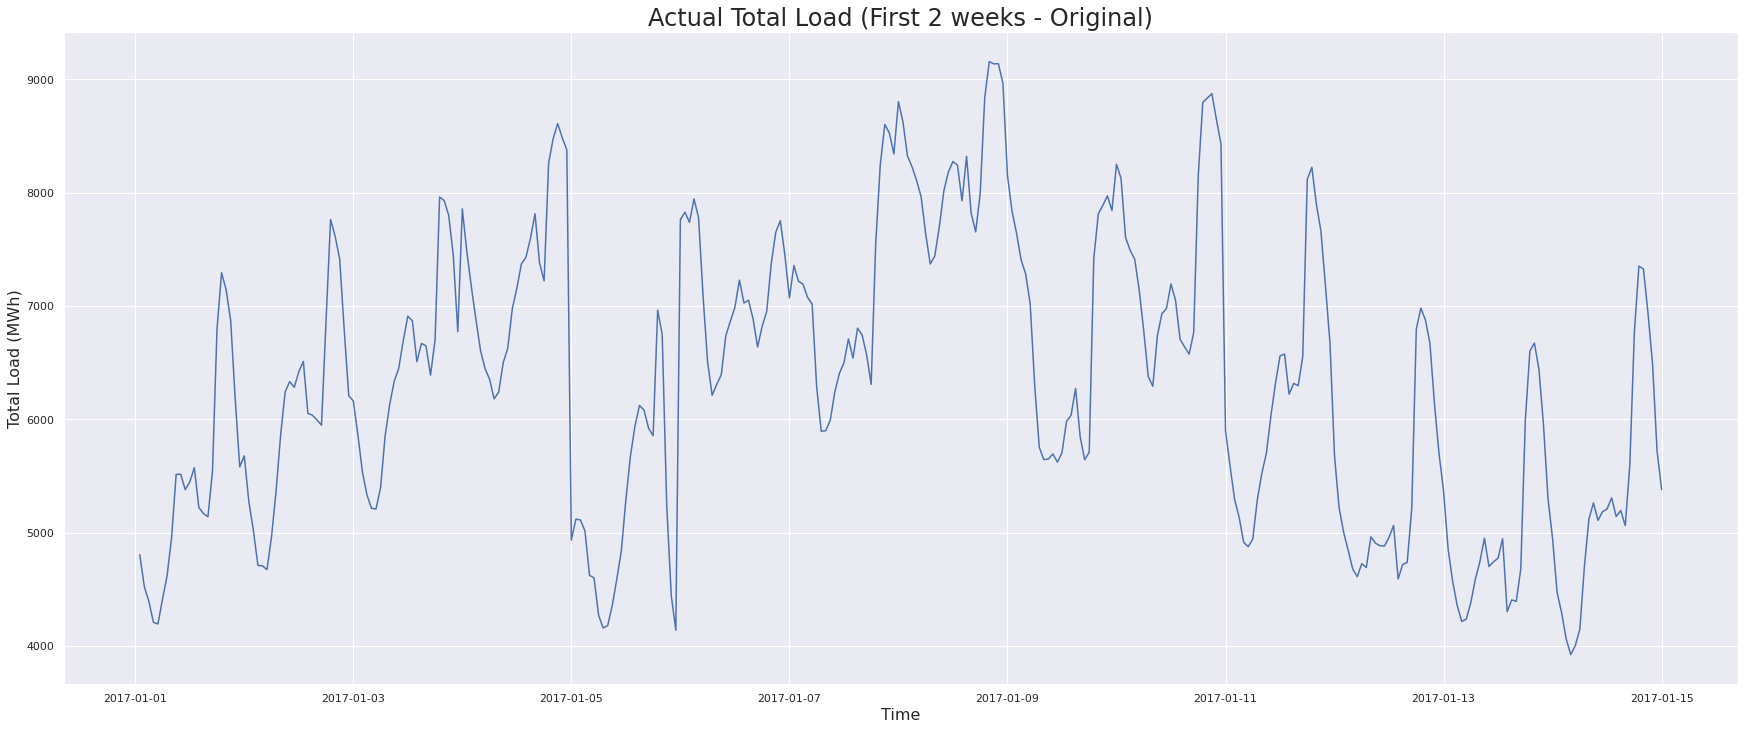

In [13]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df=df_weather, column='loads', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

What about 'wind_speed' however?

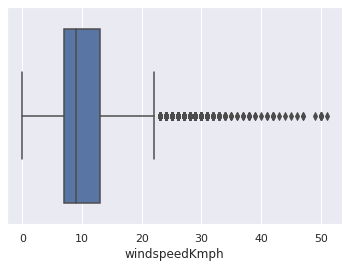

In [14]:
# Check for outliers in 'wind_speed' column

sns.boxplot(x=df_weather['windspeedKmph'])
plt.show()

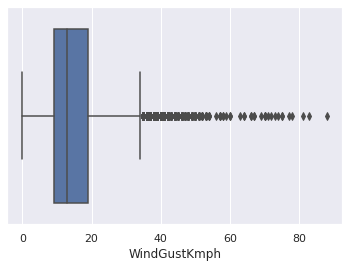

In [15]:
sns.boxplot(x=df_weather['WindGustKmph'])
plt.show()

In [16]:
cols = ['WindGustKmph','windspeedKmph']
Q1 = df_weather[cols].quantile(0.25)
Q3 = df_weather[cols].quantile(0.75)
IQR = Q3 - Q1

df_weather = df_weather[~((df_weather[cols] < (Q1 - 1.5 * IQR)) |(df_weather[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

after outlier removal

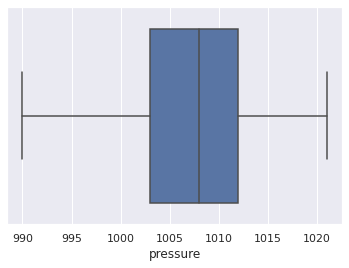

In [17]:
sns.boxplot(x=df_weather['pressure'])
plt.show()

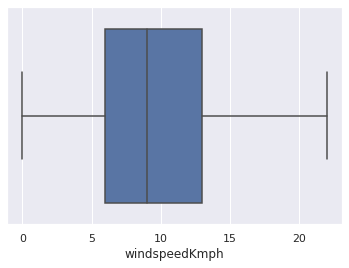

In [18]:
sns.boxplot(x=df_weather['windspeedKmph'])
plt.show()

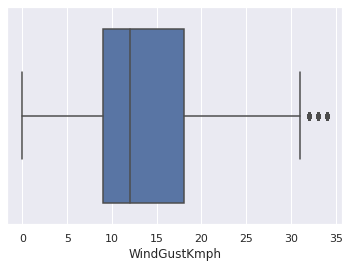

In [19]:
sns.boxplot(x=df_weather['WindGustKmph'])
plt.show()

In [20]:
df_final = df_weather

# <a id='ref30'>2. Visualizations and Time Series Analysis</a>

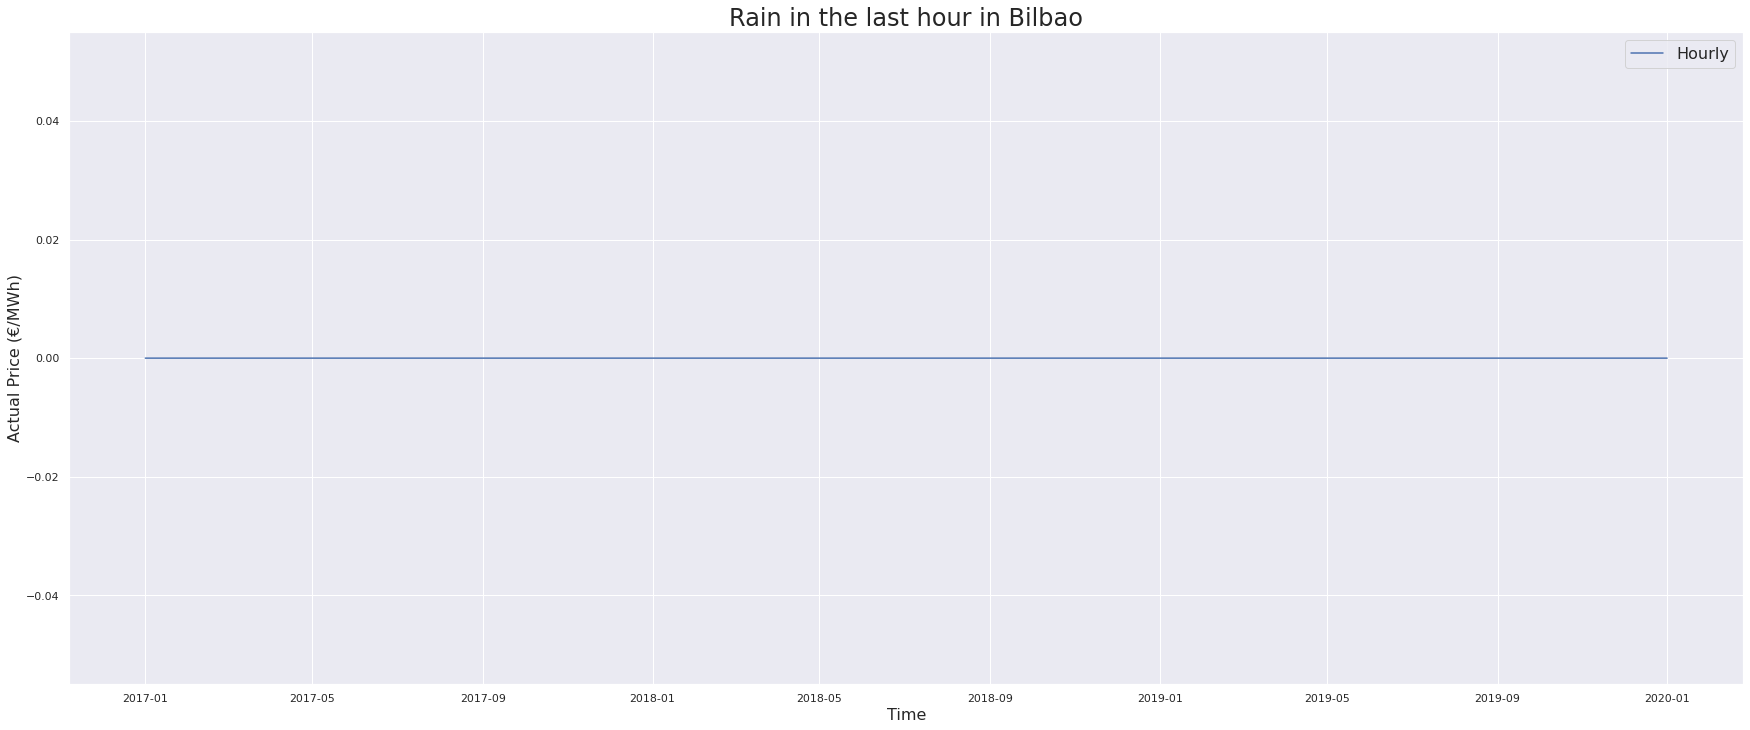

In [21]:
# Plot the 'totalSnow_cm'

ax = plot_series(df_final, 'totalSnow_cm', 
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()

From the figure above, we can conclude that **'totalSnow_cm' is an unreliable feature which will drop from the dataset**.

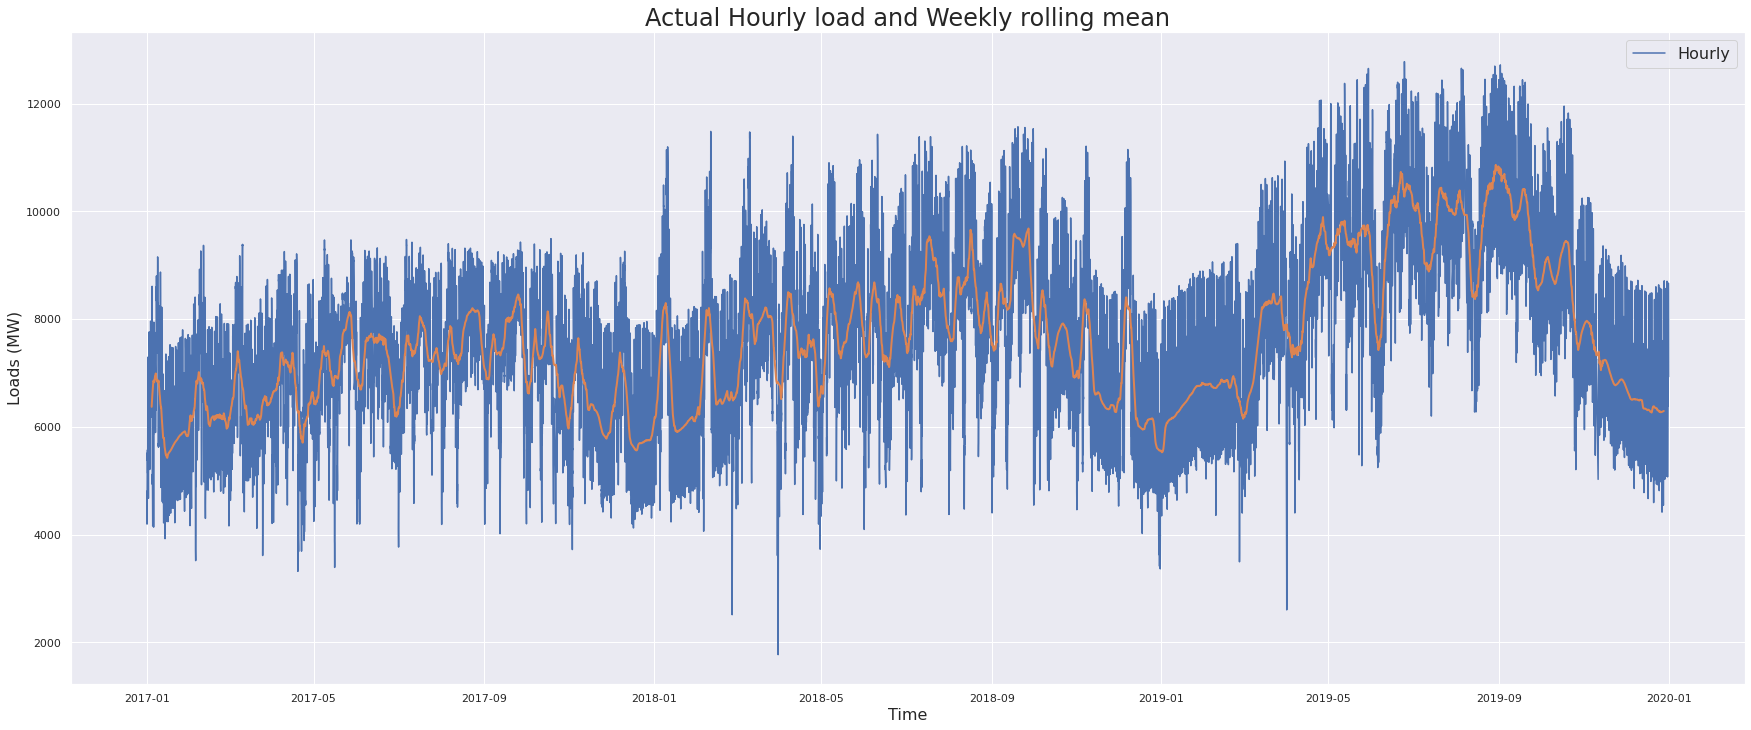

In [22]:
# Plot the load, along with the weekly rolling mean

rolling = df_final['loads'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'loads', label='Hourly', ylabel='Loads (MW)',
                 title='Actual Hourly load and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

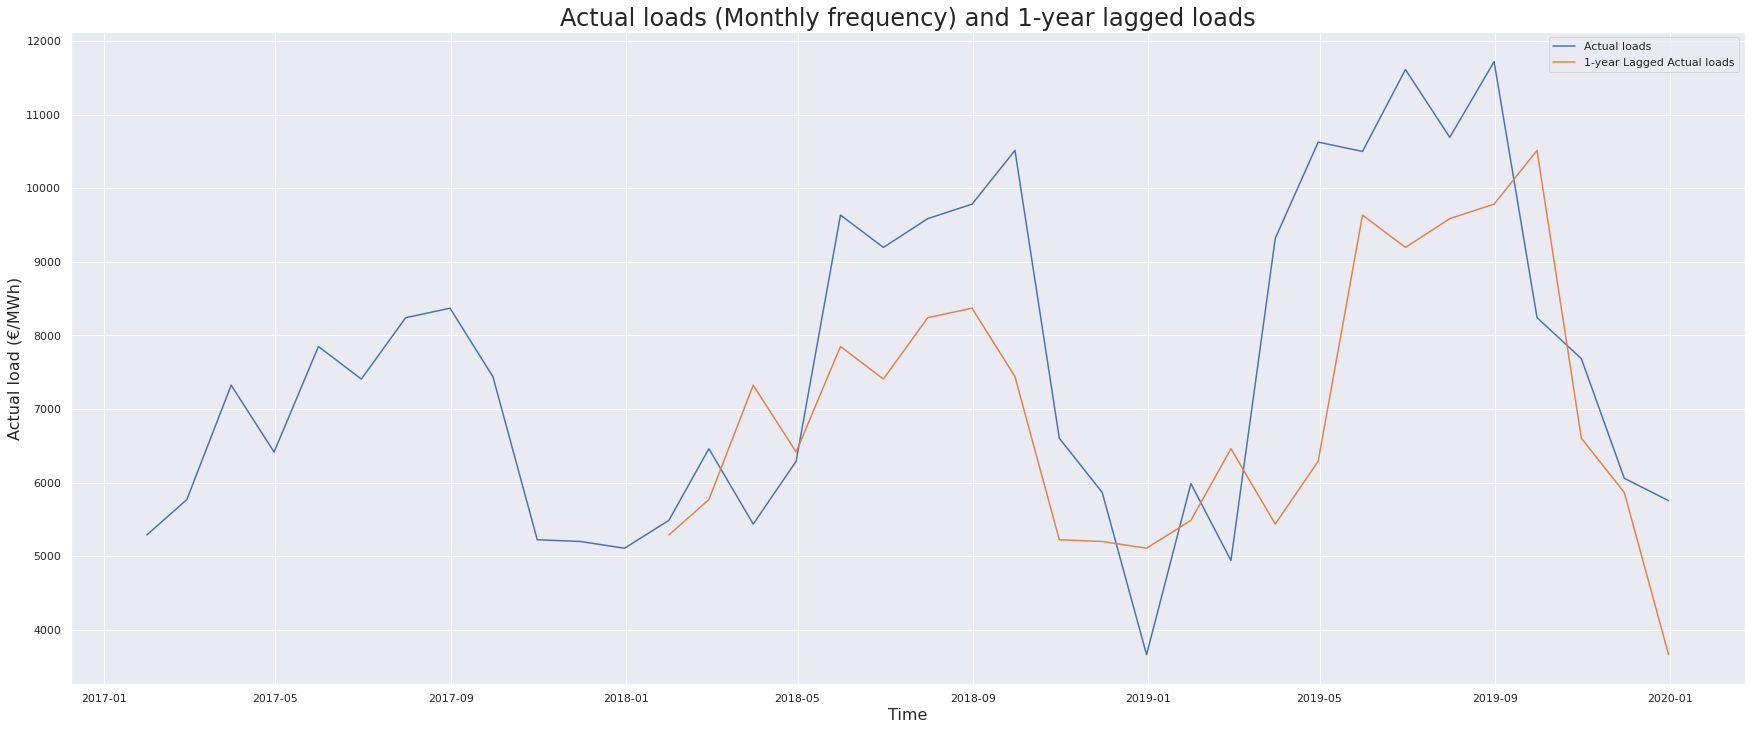

In [107]:
# Plot the loads (monthly frequence) along with its 1-year lagged series

monthly_price = df_final['loads'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual load (€/MWh)',
                 title='Actual loads (Monthly frequency) and 1-year lagged loads')
shifted = df_final['loads'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual loads', '1-year Lagged Actual loads'])
plt.savefig('1.png')
plt.show()

The figure above shows the (resampled) monthly frequency of the actual loads, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed **seasonal patterns at the monthly scale**, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual loads at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

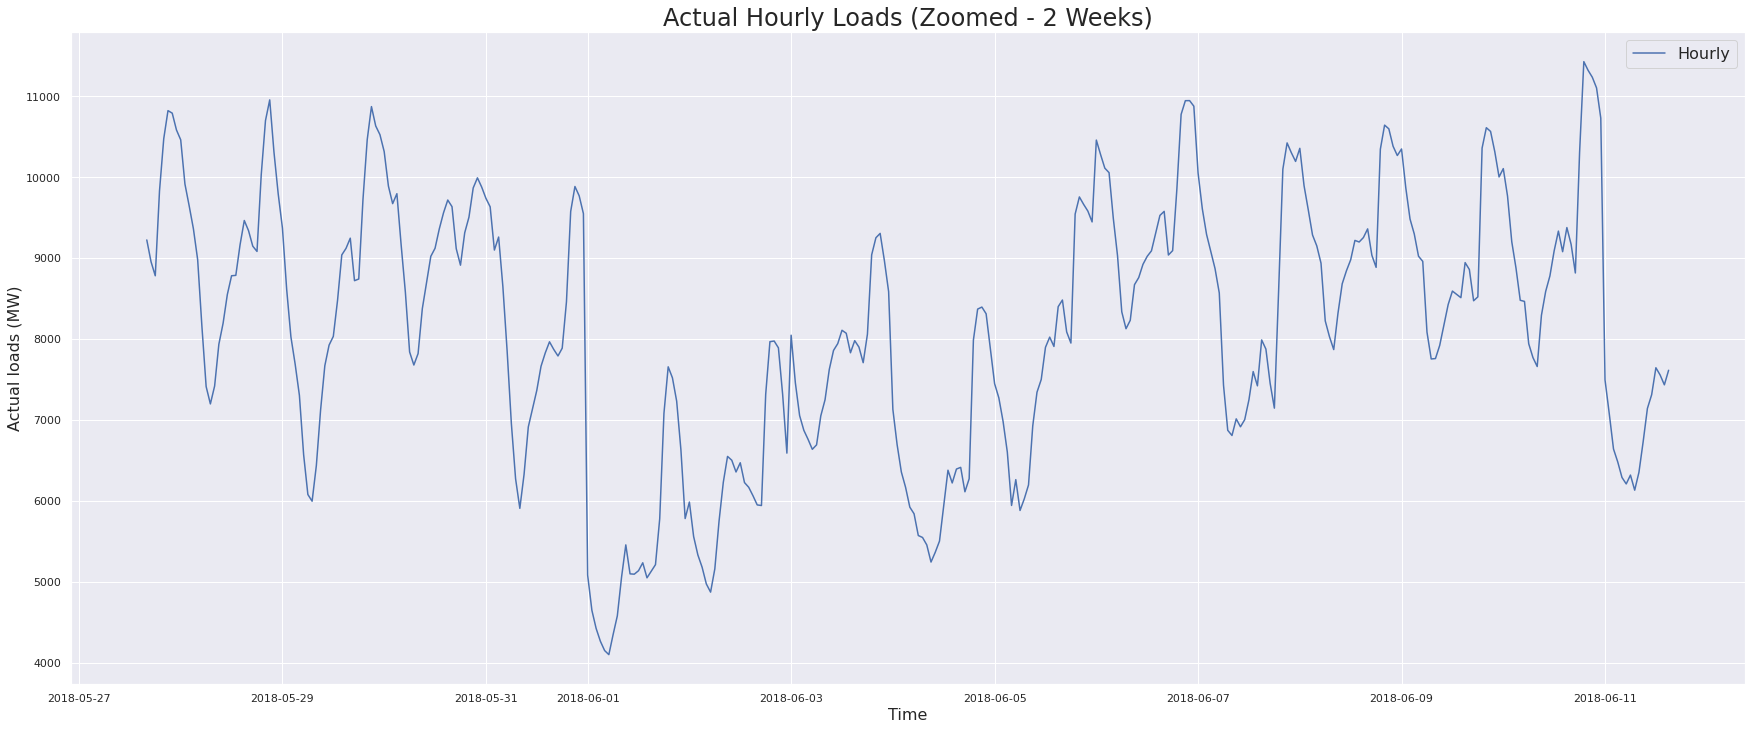

In [101]:
# Plot the actual electricity price at a daily/weekly scale

ax = plot_series(df_final, 'loads', label='Hourly', ylabel='Actual loads (MW)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Loads (Zoomed - 2 Weeks)')
plt.savefig('1.png')
plt.show()



In the figure above, we have plotted that actual hourly loads from 27/05/2018 (Sunday) at 00:00 up to 10/06/2018 (Sunday) at 23:00, i.e. two weeks of data. We can observe that there are many patterns and periodicities, such as:
- A periodicity from week to week, as the loads tends to be higher during business days and lower during weekends and especially during sundays.
- An intradyay periodicity, as the price is higher during the day and lower during the night.
- A periodicity within the business hours, as in some cases the loads drops for a few hours, which is probably due to lunch break between 01:30PM and 04:30PM.
Later on, we will make sure that we will generate features which contain these kinds of information.

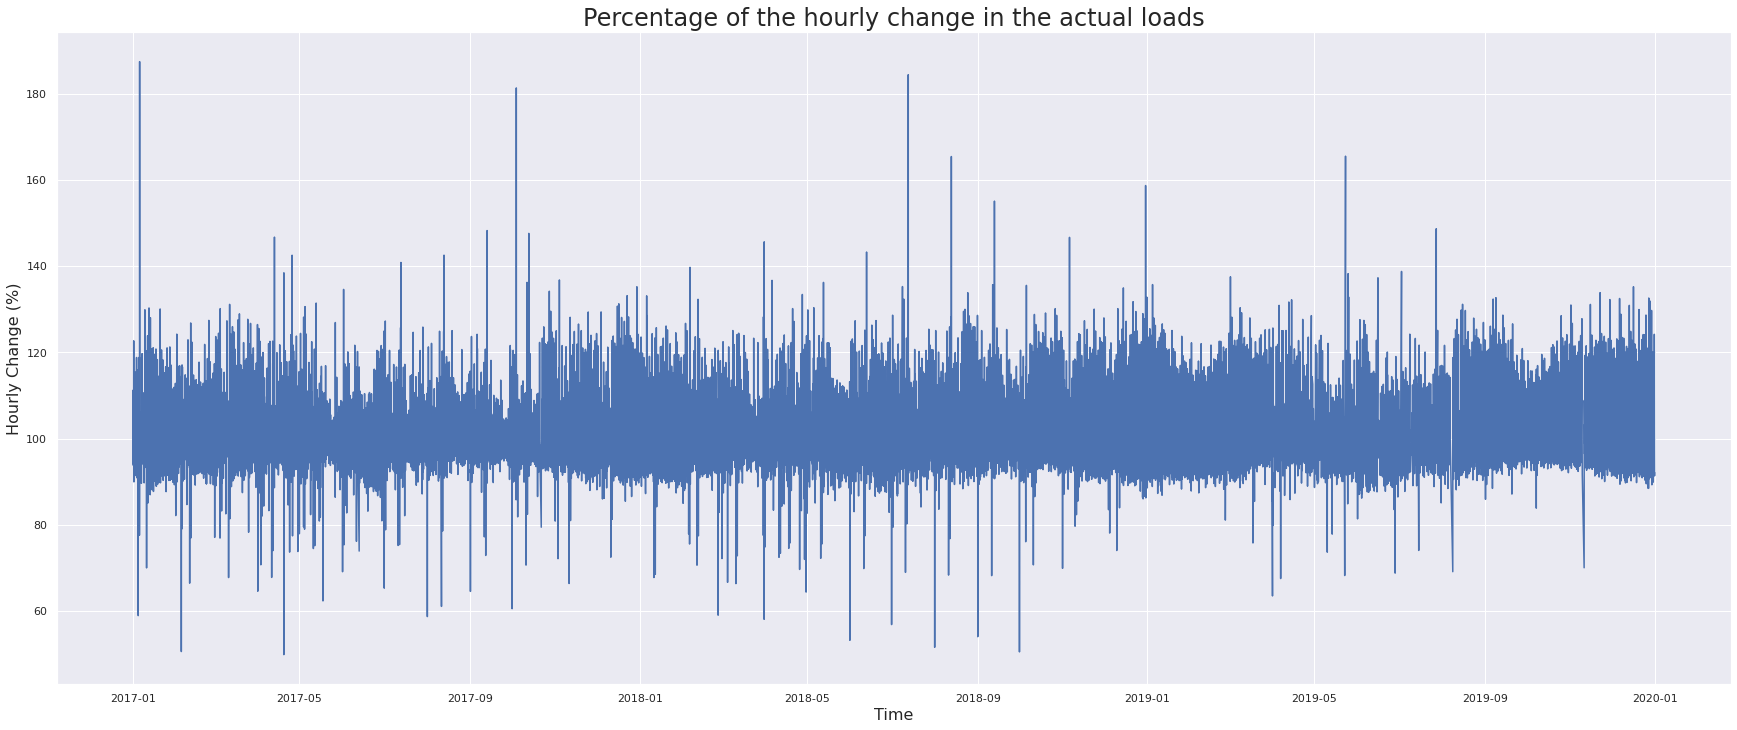

In [102]:
# Plot the percentage of the hourly change in the actual electricity price

change = df_final['loads'].div(df_final['loads'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual loads')
plt.savefig('1.png')
plt.show()

From the figure above, we can see that the change in the actual price from hour to hour is in most of the cases between -10% (actual price \* 0.9) and +20% (actual price \* 1.2). However, there are also very few outliers which show that the price gets halved (-50%) or doubled (+90%).

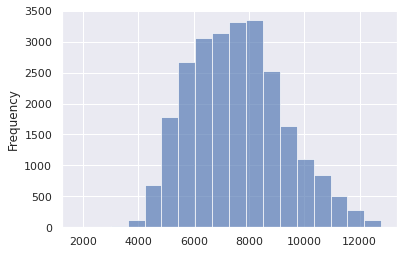

In [26]:
# Plot the histogram of the actual electricity price

ax = df_final['loads'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the actual energy price roughly follows a normal distribution and thus, could be standardized. However, we also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series. 

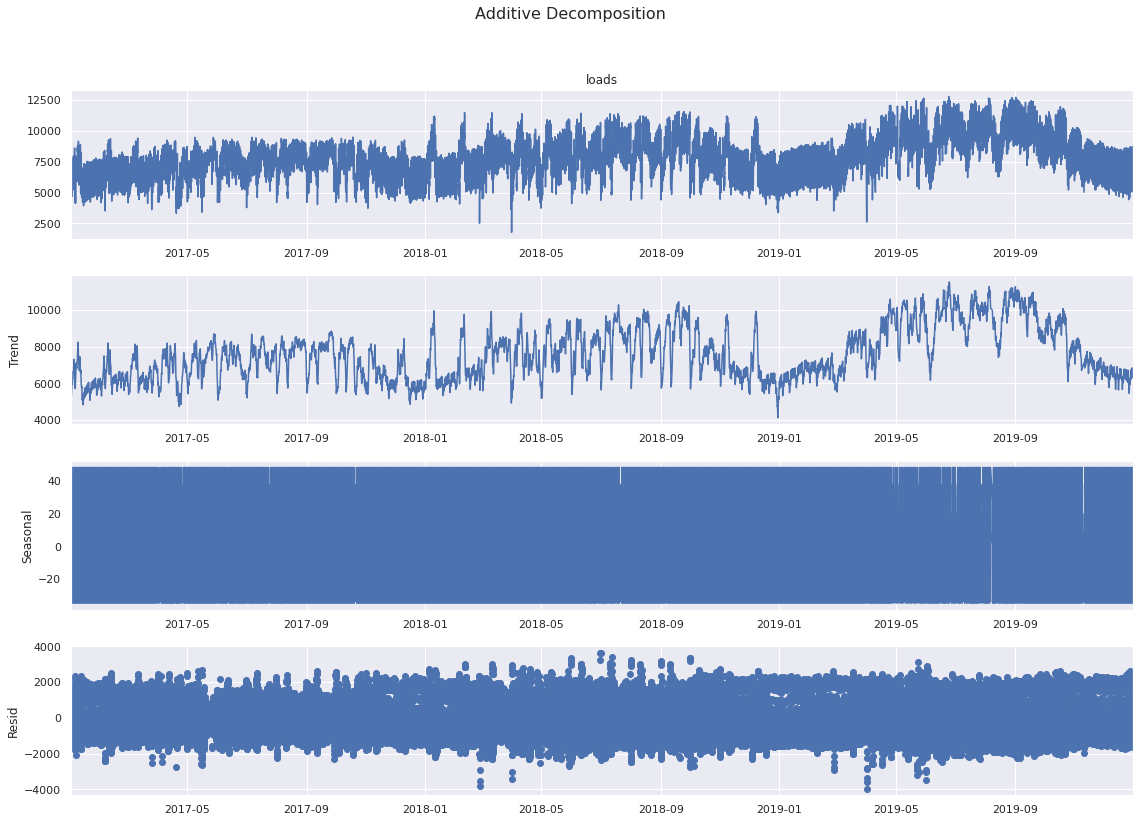

In [27]:
# Decompose the electricity price time series

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Additive Decomposition
additive_decomposition = seasonal_decompose(df_final['loads'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})


additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

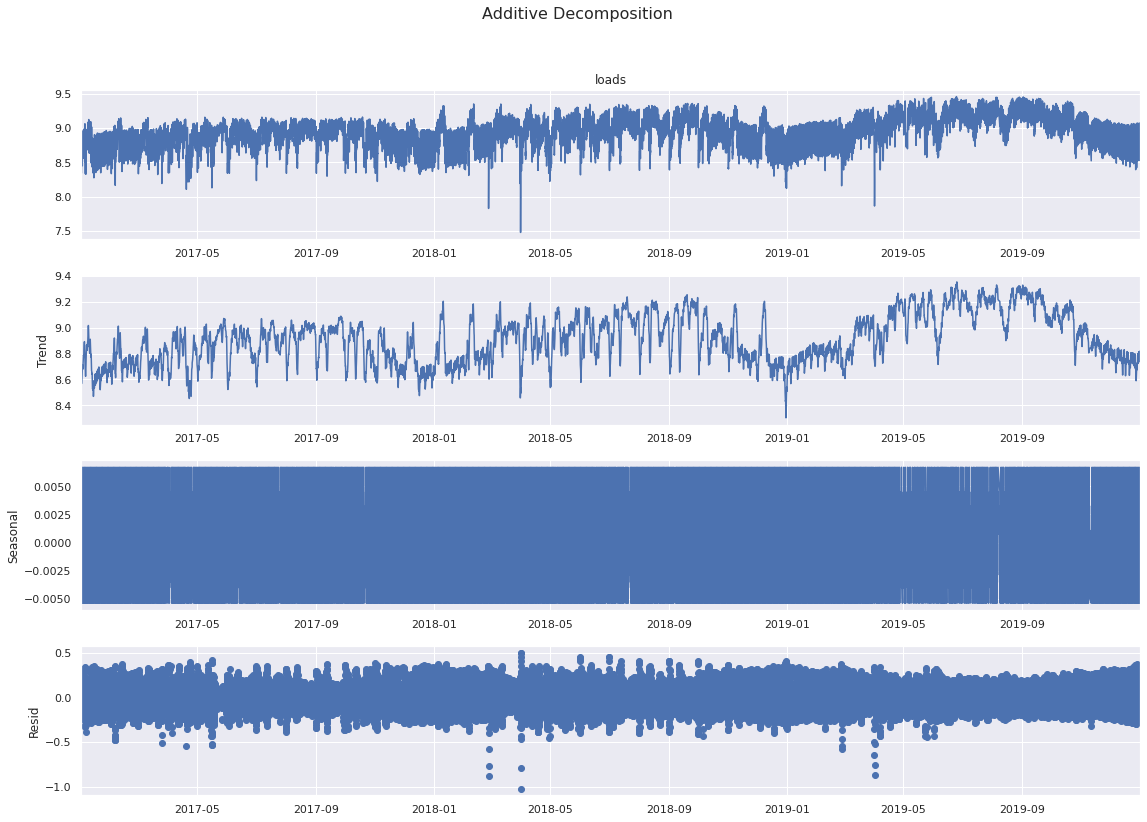

In [28]:
# Decompose the log electricity price time-series


# Additive Decomposition
additive_decomposition = seasonal_decompose(np.log(df_final['loads']), model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})


additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

The **Augmented Dickey-Fuller (ADF) test**, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [29]:
y = df_final['loads']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -8.256870
p-value: 0.000000
#Lags used: 48
Critical Value (1%): -3.430610
Critical Value (5%): -2.861655
Critical Value (10%): -2.566831


The ADF statistic (-8.25) is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for  stationarity. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: The time series is level, i.e. it is stationary around a constant.
- **Alternate Hypothesis** $H_{1}$: There is a unit root in the time series and thus it not stationary.

In [30]:
kpss_test = kpss(y, regression='c',  nlags='auto')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 6.453684
p-value: 0.010000
#Lags used: 86
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


The KPSS statistic (6.453) is higher than the critical value at 1% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that the time series is stationary or stationary around a constant.

Both tests concluded that the electricity price time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models.

## <a id='ref14'>2.2. Autocorrelation, partial autocorrelation and cross-correlation</a> 

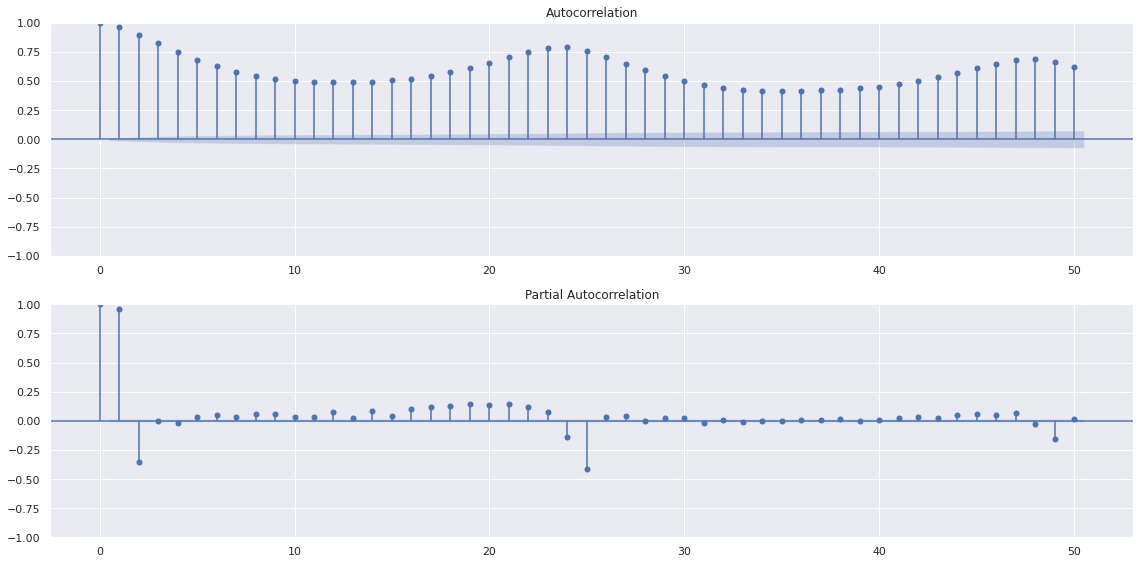

In [31]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 8))
plot_acf(df_final['loads'], lags=50, ax=ax1)
plot_pacf(df_final['loads'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

The partial autocorrelation plot of the eletricity price time series shows that the direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24 and t-25 time-steps and diminishes afterwards. Thus, we are going to use the 25 previous values of each time series which will constitute a feature for our models. 

In [32]:
# Find the correlations between the electricity price and the rest of the features

correlations = df_final.corr(method='pearson')
print(correlations['loads'].sort_values(ascending=False).to_string())

loads                1.000000
mintempC             0.476712
FeelsLikeC           0.454466
HeatIndexC           0.452791
DewPointC            0.404164
tempC                0.396745
WindChillC           0.395888
sunHour              0.389021
maxtempC             0.361768
uvIndex              0.337070
WindGustKmph         0.237356
windspeedKmph        0.211648
cloudcover           0.191685
humidity             0.164791
moon_illumination    0.005948
precipMM             0.004759
visibility          -0.015721
winddirDegree       -0.044015
pressure            -0.466351
totalSnow_cm              NaN


In [33]:
df_final = df_final.drop(['totalSnow_cm','location','moonrise', 'moonset', 'sunrise', 'sunset'], axis=1)

In [34]:
df_final

,maxtempC,mintempC,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,loads
time,,,,,,,,,,,,,,,,,,,
2017-01-01 01:00:00+00:00,32,19,8.7,7,22,17,23,25,23,8,2,67,0.0,1015,20,10,293,5,4807.00
2017-01-01 02:00:00+00:00,32,19,8.7,7,22,17,23,25,23,7,2,68,0.0,1015,22,10,297,5,4525.00
2017-01-01 03:00:00+00:00,32,19,8.7,7,22,17,25,25,23,6,2,69,0.0,1014,23,10,300,5,4395.00
2017-01-01 04:00:00+00:00,32,19,8.7,7,22,16,22,23,22,8,3,70,0.0,1015,22,10,312,5,4211.00
2017-01-01 05:00:00+00:00,32,19,8.7,7,22,15,20,21,20,9,4,72,0.0,1015,20,10,324,5,4197.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00+00:00,28,19,8.7,6,32,12,25,25,22,12,16,51,0.0,1015,22,10,312,8,8669.19
2019-12-31 20:00:00+00:00,28,19,8.7,6,32,12,22,25,22,13,13,52,0.0,1016,22,10,322,8,8494.27
2019-12-31 21:00:00+00:00,28,19,8.7,6,32,11,21,24,21,13,10,53,0.0,1017,21,10,332,8,8234.27


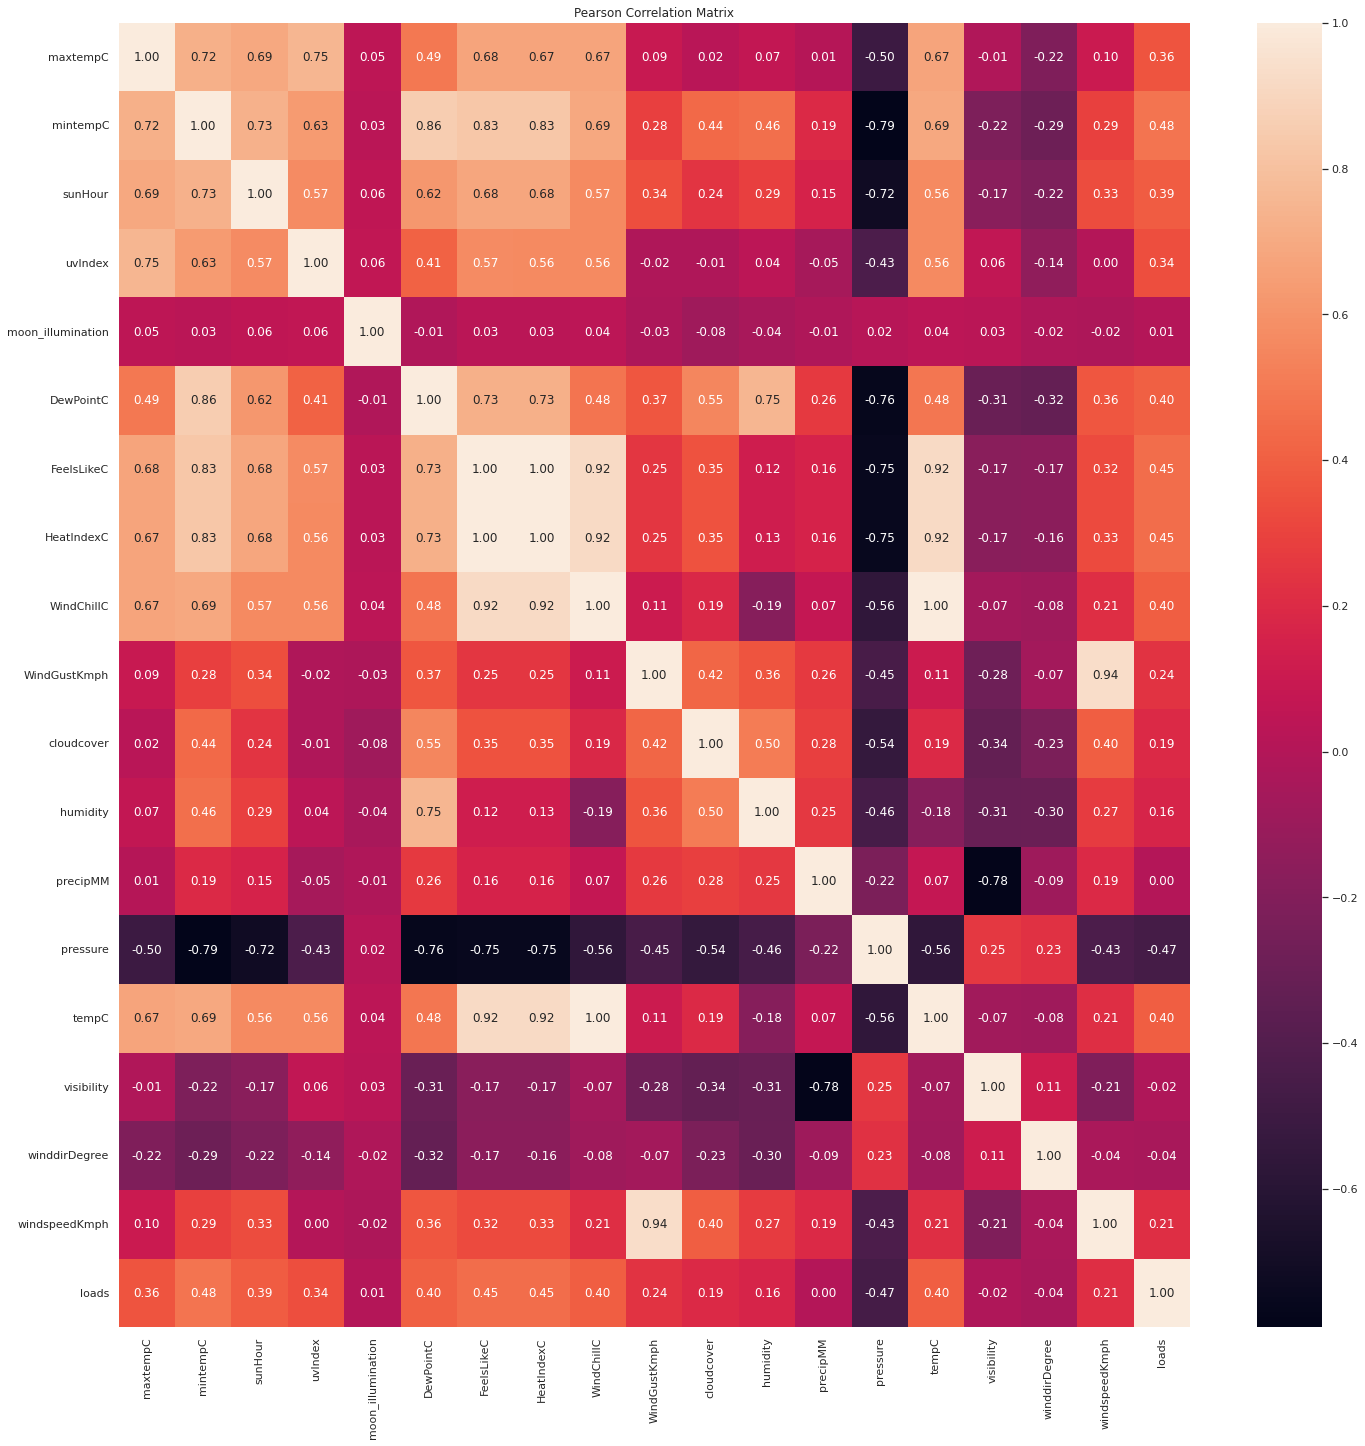

In [35]:
# Plot Pearson correlation matrix

correlations = df_final.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While we cannot make a lot out of the above correlation matrix, we can observe that there quite a lot of features that are highly correlated with each other.

In [36]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

maxtempC       uvIndex          0.751072
mintempC       DewPointC        0.859587
               FeelsLikeC       0.831510
               HeatIndexC       0.829710
uvIndex        maxtempC         0.751072
DewPointC      mintempC         0.859587
               humidity         0.754922
FeelsLikeC     mintempC         0.831510
               HeatIndexC       0.998397
               WindChillC       0.920138
               tempC            0.920292
HeatIndexC     mintempC         0.829710
               FeelsLikeC       0.998397
               WindChillC       0.917135
               tempC            0.917182
WindChillC     FeelsLikeC       0.920138
               HeatIndexC       0.917135
               tempC            0.998566
WindGustKmph   windspeedKmph    0.935152
humidity       DewPointC        0.754922
tempC          FeelsLikeC       0.920292
               HeatIndexC       0.917182
               WindChillC       0.998566
windspeedKmph  WindGustKmph     0.935152


# <a id='ref15'>3. Feature Engineering</a>

## <a id='ref16'>3.1. Feature generation</a> 

In [37]:
# Generate 'hour', 'weekday' and 'month' features

for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

A very useful feature that we will generate, has to do with the business hours, i.e. whether businesses are open or not in a given hour. However, there is a certain peculiarity as the 9AM-5PM working day is not generally followed by all types of businesses, due to a lunch break in between. The most usual business hours are from Sunday-Thursday, from 10:00AM-4:00PM and then again from 6:00PM-10PM.

Therefore, the value of the 'business hour' will be equal to '2' if the given hour is within the business hours, equal to '1' if the given hour is within the lunch break in between and equal to '0' for all other given hours.

In [38]:
# Generate 'weekend' feature

for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 5):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 4):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In order to reduce the dimensionality and potentially acquire a new kind of information, for every given hour, we will subtract the minimum temperature ('temp_min') from the maximum temperature ('temp_max') and we will name that feature 'temp_range'.

In [39]:
for i in range(len(df_final)):
    position = df_final.index[i]
    temp_max = df_final.loc[position, 'maxtempC']
    temp_min = df_final.loc[position, 'mintempC']
    df_final.loc[position, 'temp_range'] = abs(temp_max - temp_min)

## <a id='ref17'>3.2. Feature selection</a> 

In [40]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [41]:
train_end_idx = 19371
cv_end_idx = 22282
test_end_idx = 25158

In [42]:
df_final.index[22283:]

DatetimeIndex(['2019-08-30 18:00:00+00:00', '2019-08-30 19:00:00+00:00',
               '2019-08-30 20:00:00+00:00', '2019-08-30 21:00:00+00:00',
               '2019-08-30 22:00:00+00:00', '2019-08-30 23:00:00+00:00',
               '2019-08-31 00:00:00+00:00', '2019-08-31 01:00:00+00:00',
               '2019-08-31 02:00:00+00:00', '2019-08-31 03:00:00+00:00',
               ...
               '2019-12-31 14:00:00+00:00', '2019-12-31 15:00:00+00:00',
               '2019-12-31 16:00:00+00:00', '2019-12-31 17:00:00+00:00',
               '2019-12-31 18:00:00+00:00', '2019-12-31 19:00:00+00:00',
               '2019-12-31 20:00:00+00:00', '2019-12-31 21:00:00+00:00',
               '2019-12-31 22:00:00+00:00', '2019-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=2875, freq=None)

In [43]:
X = df_final[df_final.columns.drop('loads')].values
y = df_final['loads'].values

y = y.reshape(-1, 1)

In [44]:
X

array([[32. , 19. ,  8.7, ...,  0. ,  1. , 13. ],
       [32. , 19. ,  8.7, ...,  0. ,  1. , 13. ],
       [32. , 19. ,  8.7, ...,  0. ,  1. , 13. ],
       ...,
       [28. , 19. ,  8.7, ...,  0. , 12. ,  9. ],
       [28. , 19. ,  8.7, ...,  0. , 12. ,  9. ],
       [28. , 19. ,  8.7, ...,  0. , 12. ,  9. ]])

In [45]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [46]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [47]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [48]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

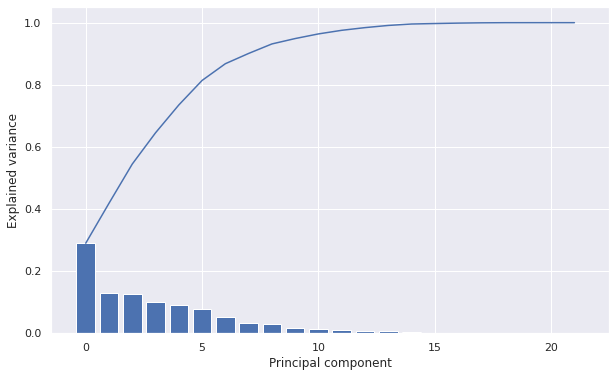

In [49]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [50]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [51]:
X_pca.shape

(25158, 6)

In [52]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [53]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [54]:
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [55]:
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [56]:
batch_size = 256
buffer_size = 1000

In [57]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

2022-04-19 18:23:45.801773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 18:23:45.880694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 18:23:45.881509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 18:23:45.884455: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [58]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [59]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

# <a id='ref18'>4. Load Forecasting</a> 

In [60]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

## <a id='ref20'>4.1. XGBoost</a> 

In [61]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [62]:
param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

[18:23:50] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:23:50] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.15585	eval-rmse:0.31990
[1]	train-rmse:0.15148	eval-rmse:0.31163
[2]	train-rmse:0.14725	eval-rmse:0.30365
[3]	train-rmse:0.14317	eval-rmse:0.29560
[4]	train-rmse:0.13921	eval-rmse:0.28781
[5]	train-rmse:0.13538	eval-rmse:0.28053
[6]	train-rmse:0.13168	eval-rmse:0.27321
[7]	train-rmse:0.12810	eval-rmse:0.26607
[8]	train-rmse:0.12462	eval-rmse:0.26029
[9]	train-rmse:0.12123	eval-rmse:0.25426
[10]	train-rmse:0.11812	eval-rmse:0.24915
[11]	train-rmse:0.11496	eval-rmse:0.24303
[12]	train-rmse:0.11190	eval-r

In [65]:
forecast = xgb_model.predict(dtest)

xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)
xgb_forecast_inv
rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead Load XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

RMSE of hour-ahead Load XGBoost forecast: 444.033


In [66]:
xgb_forecast_inv

array([[10436.064 ],
       [10172.723 ],
       [ 9980.815 ],
       ...,
       [ 8176.552 ],
       [ 7872.6113],
       [ 7091.287 ]], dtype=float32)

## <a id='ref21'>4.2. LSTM</a> 

In [67]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.0003, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [68]:
history = multivariate_lstm.fit(train, epochs=100,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/100


2022-04-19 18:36:02.492511: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-19 18:36:03.373231: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


76/76 [==============================] - 4s 10ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1036
Epoch 2/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 3/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0074 - root_mean_squared_error: 0.0862 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0065 - root_mean_squared_error: 0.0803 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0902
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846
Epoch 6/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - val_loss: 0.0070 - val_root_mean_squared

<Figure size 1152x864 with 0 Axes>

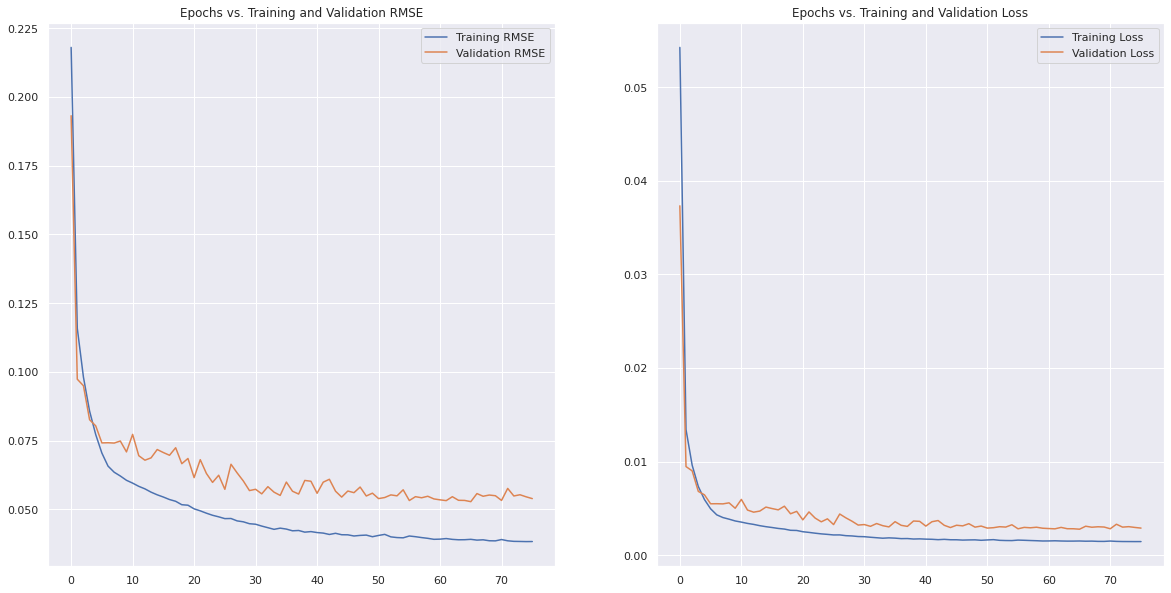

In [112]:
plt.savefig('1.png')
plot_model_rmse_and_loss(history)

In [70]:
scaler_y.inverse_transform(y_test[6:30])

array([[12342.77],
       [12323.8 ],
       [11863.77],
       [11233.77],
       [10965.77],
       [10698.77],
       [10490.77],
       [ 9012.53],
       [ 9084.16],
       [ 9889.94],
       [10167.3 ],
       [10472.03],
       [10637.55],
       [10804.01],
       [10883.51],
       [11385.58],
       [11310.89],
       [10792.83],
       [10189.46],
       [12245.71],
       [12667.44],
       [12719.32],
       [12511.07],
       [12281.07]])

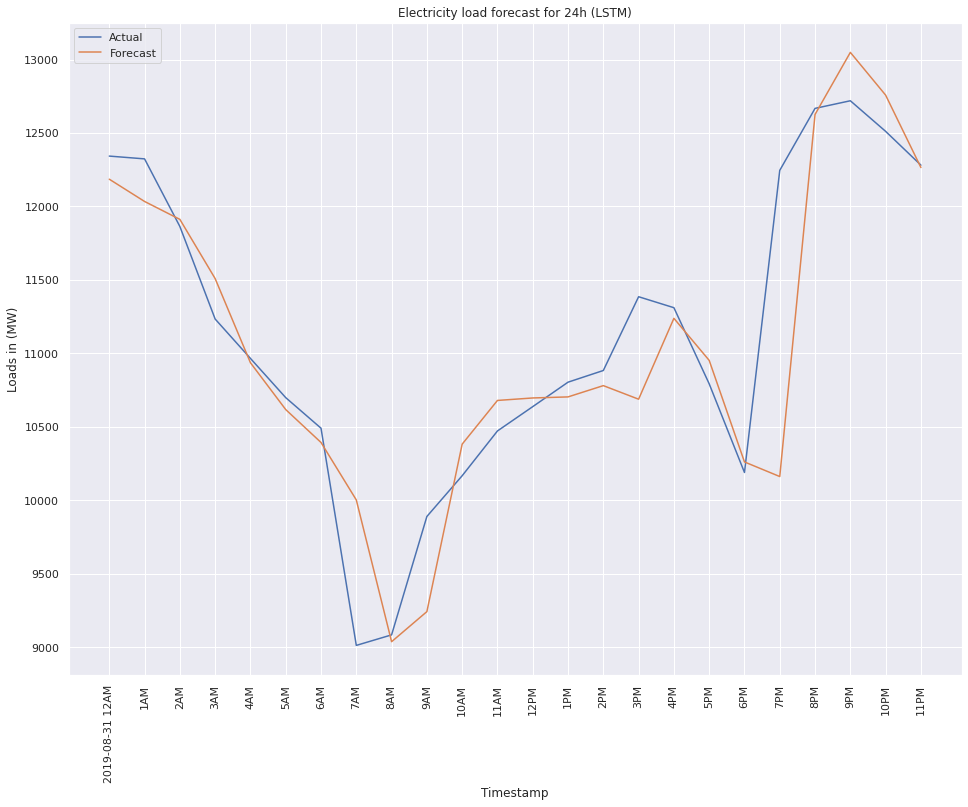

In [113]:
forecast = multivariate_lstm.predict(X_test[6:30])
lstm_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["2019-08-31 12AM", "1AM", "2AM", "3AM", "4AM", "5AM", "6AM", "7AM", "8AM", "9AM", "10AM", "11AM", "12PM", "1PM", "2PM", "3PM", "4PM", "5PM", "6PM", "7PM", "8PM", "9PM", "10PM", "11PM"]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,lstm_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Electricity load forecast for 24h (LSTM)')
plt.xticks(rotation = 90)
plt.savefig('1.png')
plt.show()


In [72]:
df_final.index[22283:][6:30]

DatetimeIndex(['2019-08-31 00:00:00+00:00', '2019-08-31 01:00:00+00:00',
               '2019-08-31 02:00:00+00:00', '2019-08-31 03:00:00+00:00',
               '2019-08-31 04:00:00+00:00', '2019-08-31 05:00:00+00:00',
               '2019-08-31 06:00:00+00:00', '2019-08-31 07:00:00+00:00',
               '2019-08-31 08:00:00+00:00', '2019-08-31 09:00:00+00:00',
               '2019-08-31 10:00:00+00:00', '2019-08-31 11:00:00+00:00',
               '2019-08-31 12:00:00+00:00', '2019-08-31 13:00:00+00:00',
               '2019-08-31 14:00:00+00:00', '2019-08-31 15:00:00+00:00',
               '2019-08-31 16:00:00+00:00', '2019-08-31 17:00:00+00:00',
               '2019-08-31 18:00:00+00:00', '2019-08-31 19:00:00+00:00',
               '2019-08-31 20:00:00+00:00', '2019-08-31 21:00:00+00:00',
               '2019-08-31 22:00:00+00:00', '2019-08-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', freq=None)

In [73]:
df_final.index.year

Int64Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='time', length=25158)

In [74]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead load LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

RMSE of hour-ahead load LSTM forecast: 288.463


## <a id='ref22'>4.4. Stacked LSTM</a> 

In [75]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.0003, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [76]:
history = multivariate_stacked_lstm.fit(train, epochs=100,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/100
76/76 [==============================] - 4s 22ms/step - loss: 0.0183 - root_mean_squared_error: 0.1275 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1423
Epoch 2/100
76/76 [==============================] - 1s 12ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 3/100
76/76 [==============================] - 1s 12ms/step - loss: 0.0081 - root_mean_squared_error: 0.0902 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 4/100
76/76 [==============================] - 1s 12ms/step - loss: 0.0073 - root_mean_squared_error: 0.0853 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 5/100
76/76 [==============================] - 1s 12ms/step - loss: 0.0067 - root_mean_squared_error: 0.0817 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0988
Epoch 6/100
76/76 [==============================] - 1s 12ms/step - loss: 0.0060 - root_mean_squared_error: 0.0774 - val_loss: 0.0092 - val_

<Figure size 1152x864 with 0 Axes>

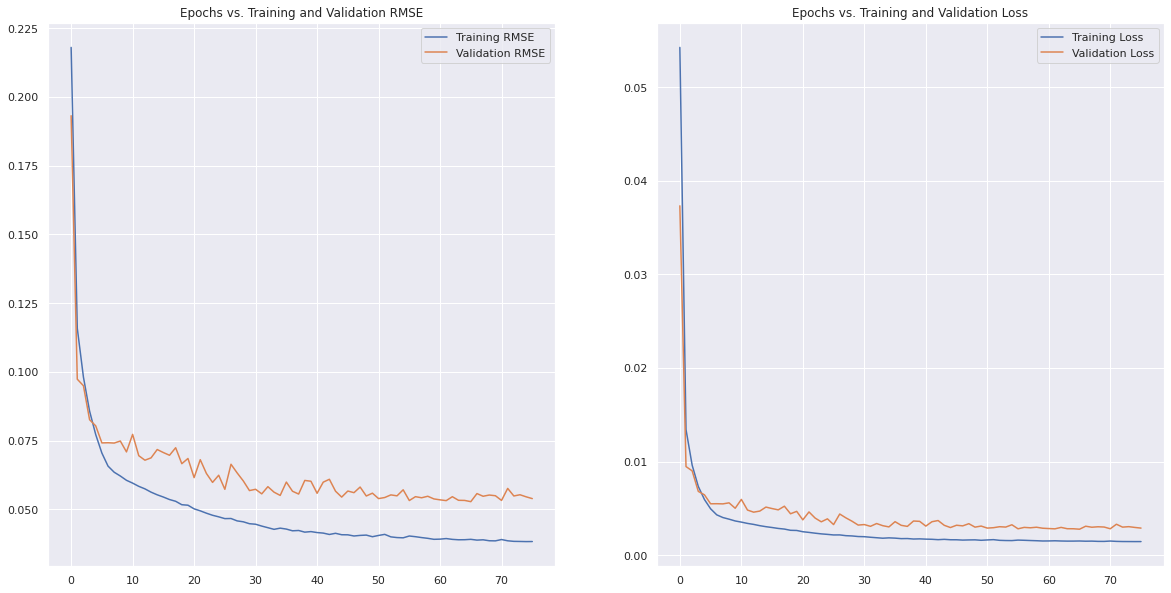

In [114]:
plt.savefig('1.png')
plot_model_rmse_and_loss(history)

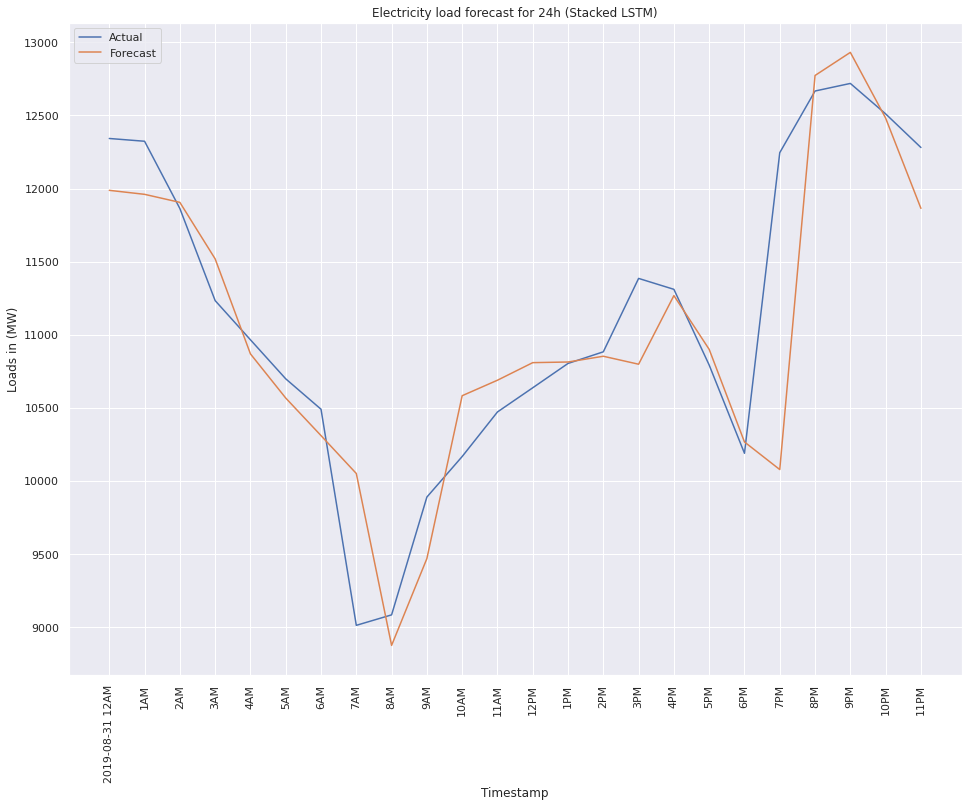

In [116]:
forecast = multivariate_stacked_lstm.predict(X_test[6:30])
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["2019-08-31 12AM", "1AM", "2AM", "3AM", "4AM", "5AM", "6AM", "7AM", "8AM", "9AM", "10AM", "11AM", "12PM", "1PM", "2PM", "3PM", "4PM", "5PM", "6PM", "7PM", "8PM", "9PM", "10PM", "11PM"]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,multivariate_stacked_lstm_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Electricity load forecast for 24h (Stacked LSTM)')
plt.xticks(rotation = 90)
plt.savefig('1.png')
plt.show()

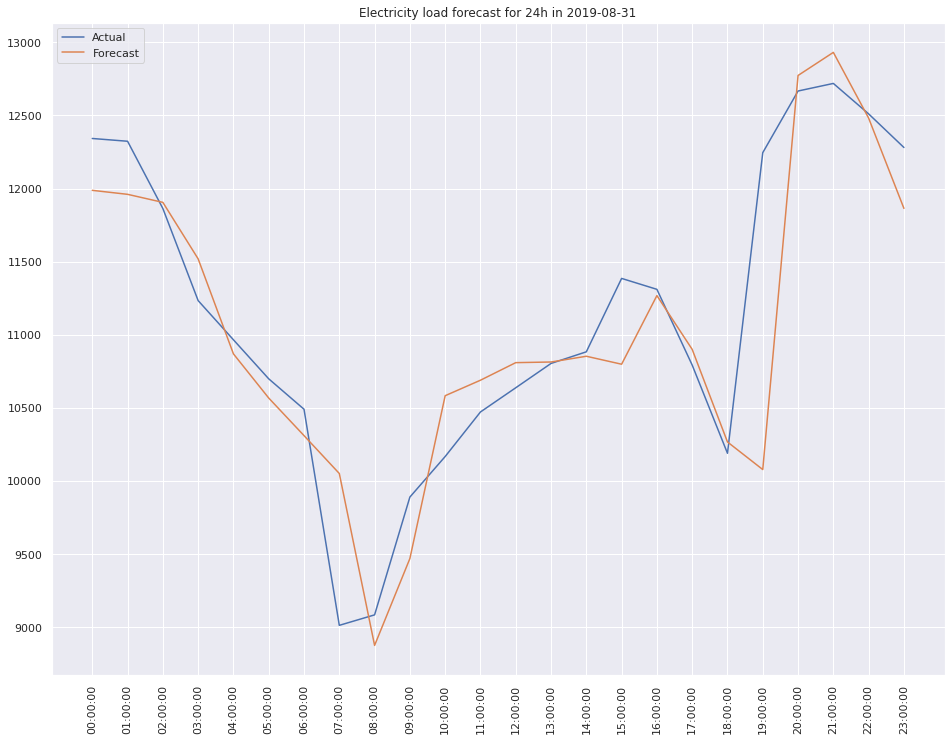

In [106]:
forecast = multivariate_stacked_lstm.predict(X_test[6:30])
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00", "08:00:00", "09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00", "18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00", "23:00:00", ]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,multivariate_stacked_lstm_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.title('Electricity load forecast for 24h in 2019-08-31')
plt.xticks(rotation = 90)
plt.savefig('1.png')
plt.show()

In [79]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of hour-ahead load multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))

RMSE of hour-ahead load multivariate Stacked LSTM forecast: 319.295


## <a id='ref23'>4.5. CNN</a> 

In [80]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.0003, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [81]:
history = multivariate_cnn.fit(train, epochs=100,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/100
76/76 [==============================] - 5s 5ms/step - loss: 0.0251 - root_mean_squared_error: 0.1488 - val_loss: 0.0178 - val_root_mean_squared_error: 0.1336
Epoch 2/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0096 - root_mean_squared_error: 0.0977 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0994
Epoch 3/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 4/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 5/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921
Epoch 6/100
76/76 [==============================] - 0s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0081 - val_root_m

<Figure size 1152x864 with 0 Axes>

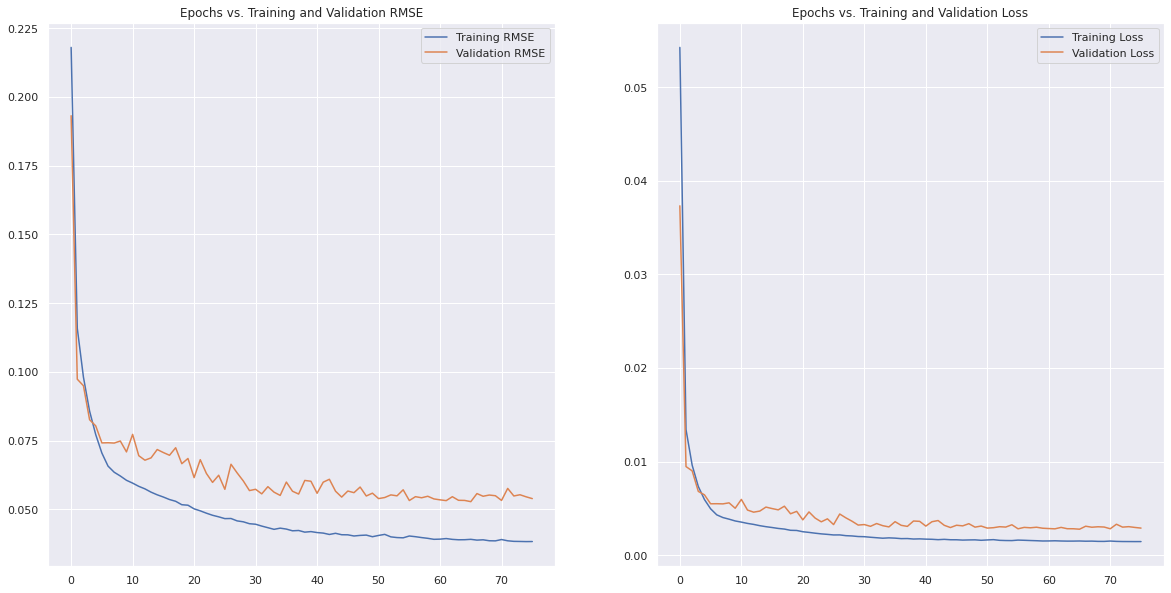

In [118]:
plt.savefig('1.png')
plot_model_rmse_and_loss(history)

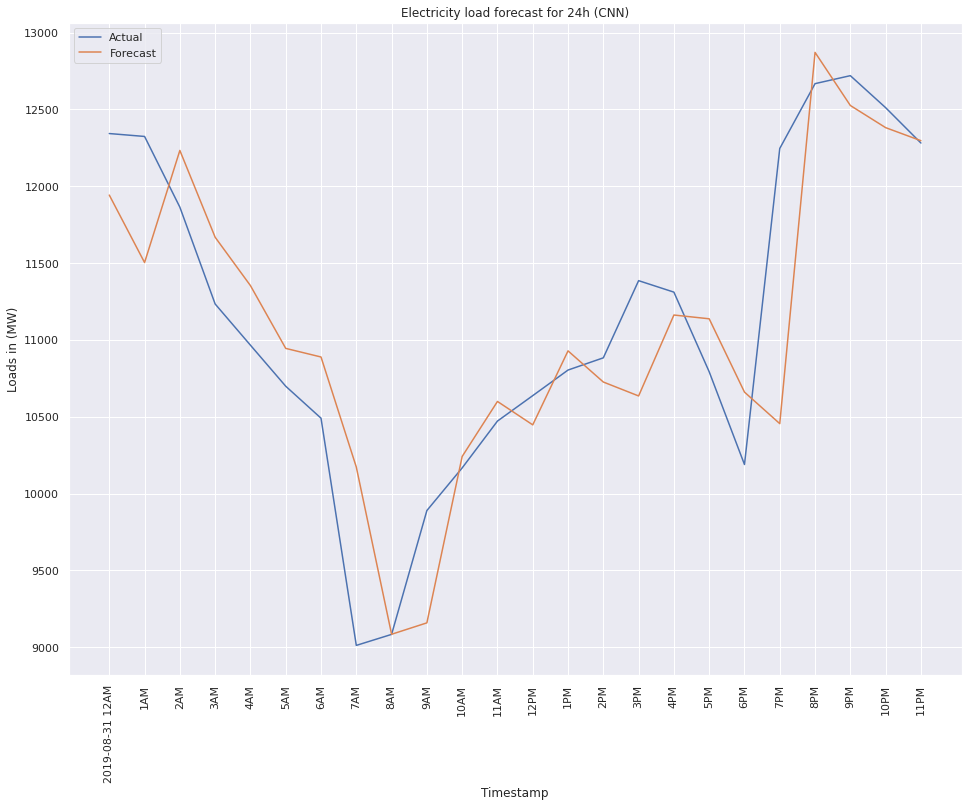

In [117]:
forecast = multivariate_cnn.predict(X_test[6:30])
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["2019-08-31 12AM", "1AM", "2AM", "3AM", "4AM", "5AM", "6AM", "7AM", "8AM", "9AM", "10AM", "11AM", "12PM", "1PM", "2PM", "3PM", "4PM", "5PM", "6PM", "7PM", "8PM", "9PM", "10PM", "11PM"]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,multivariate_cnn_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Electricity load forecast for 24h (CNN)')
plt.xticks(rotation = 90)
plt.savefig('1.png')
plt.show()

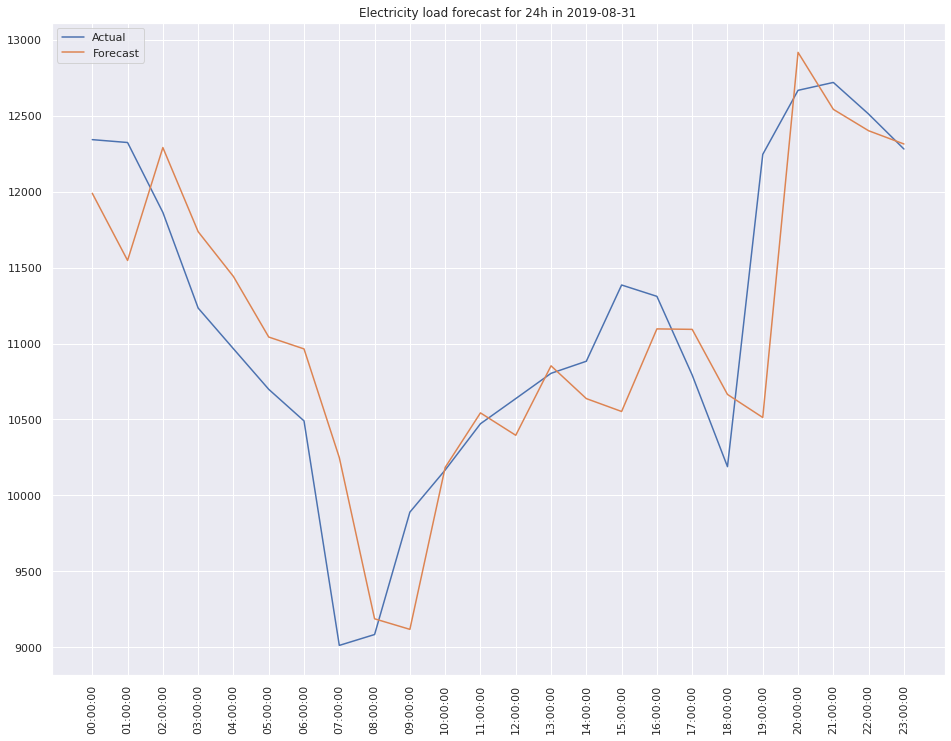

In [83]:
forecast = multivariate_cnn.predict(X_test[6:30])
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00", "08:00:00", "09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00", "18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00", "23:00:00", ]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,multivariate_cnn_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.title('Electricity load forecast for 24h in 2019-08-31')
plt.xticks(rotation = 90)
plt.show()

In [84]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of hour-ahead load multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

RMSE of hour-ahead load multivariate CNN forecast: 335.87


## <a id='ref24'>4.6. CNN-LSTM</a> 

In [85]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.0003, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [86]:
history = multivariate_cnn_lstm.fit(train, epochs=100,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/100
76/76 [==============================] - 3s 10ms/step - loss: 0.0162 - root_mean_squared_error: 0.1201 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484
Epoch 2/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 3/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 4/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0049 - root_mean_squared_error: 0.0701 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0905
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 0.0043 - root_mean_squared_error: 0.0655 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 6/100
76/76 [==============================] - 0s 6ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0066 - val_root_

<Figure size 1152x864 with 0 Axes>

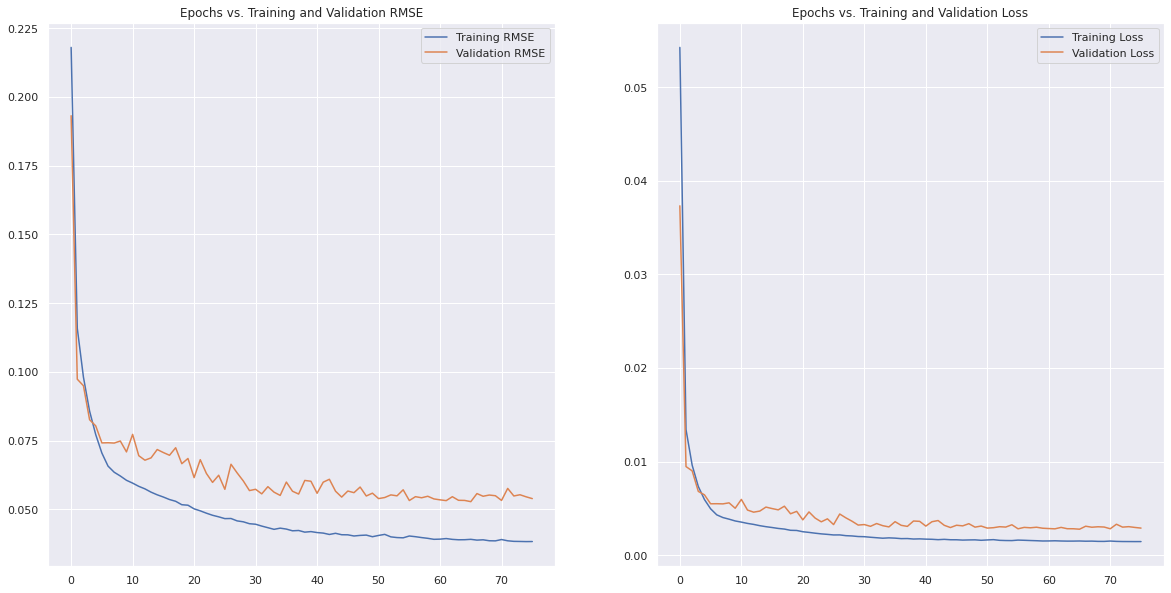

In [120]:
plt.savefig('1.png')

plot_model_rmse_and_loss(history)

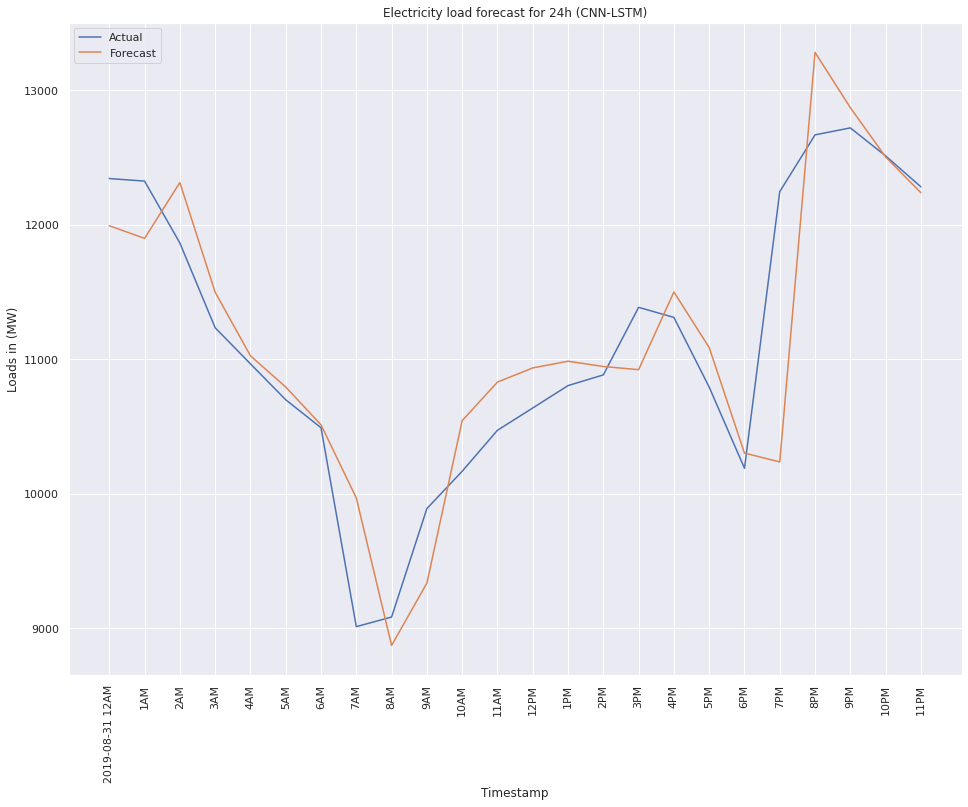

In [119]:
forecast = multivariate_cnn_lstm.predict(X_test[6:30])
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["2019-08-31 12AM", "1AM", "2AM", "3AM", "4AM", "5AM", "6AM", "7AM", "8AM", "9AM", "10AM", "11AM", "12PM", "1PM", "2PM", "3PM", "4PM", "5PM", "6PM", "7PM", "8PM", "9PM", "10PM", "11PM"]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,multivariate_cnn_lstm_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Electricity load forecast for 24h (CNN-LSTM)')
plt.xticks(rotation = 90)
plt.savefig('1.png')
plt.show()

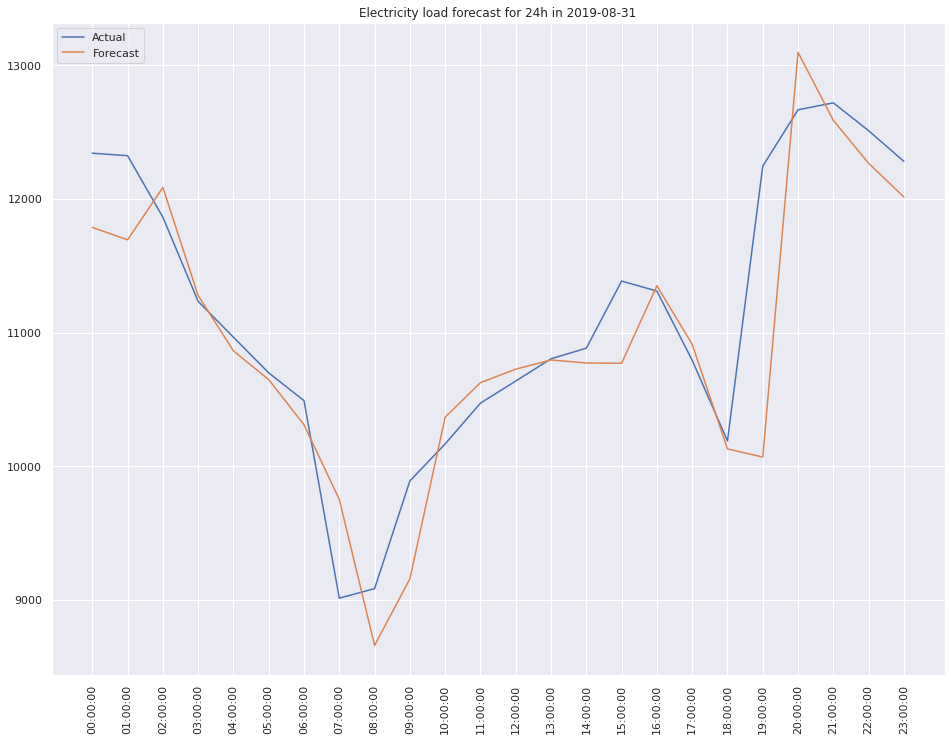

In [88]:
forecast = multivariate_cnn_lstm.predict(X_test[6:30])
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00", "08:00:00", "09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00", "18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00", "23:00:00", ]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,multivariate_cnn_lstm_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.title('Electricity load forecast for 24h in 2019-08-31')
plt.xticks(rotation = 90)
plt.show()

In [89]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of hour-ahead load multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

RMSE of hour-ahead load multivariate CNN-`LSTM forecast: 288.53


## <a id='ref25'>4.7. Time Distributed MLP</a> 

In [90]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.0003, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [91]:
history = multivariate_mlp.fit(train, epochs=100,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/100
76/76 [==============================] - 1s 5ms/step - loss: 0.0258 - root_mean_squared_error: 0.1512 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0947
Epoch 2/100
76/76 [==============================] - 0s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 3/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0053 - root_mean_squared_error: 0.0731 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 4/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0780
Epoch 5/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 6/100
76/76 [==============================] - 0s 4ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0035 - val_root_m

<Figure size 1152x864 with 0 Axes>

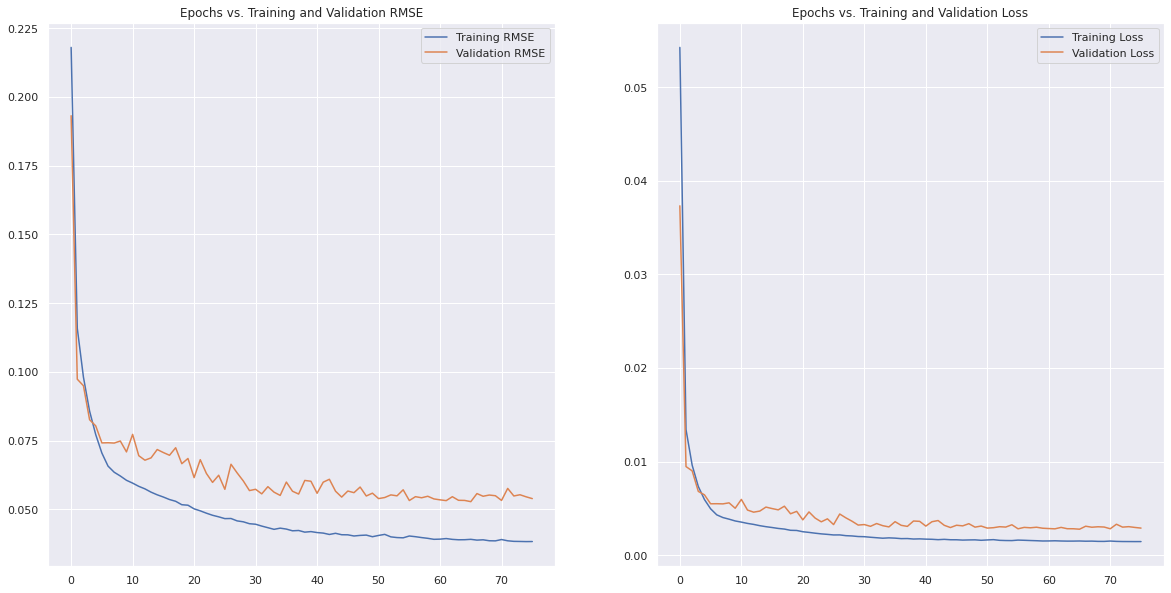

In [122]:
plt.savefig('1.png')

plot_model_rmse_and_loss(history)

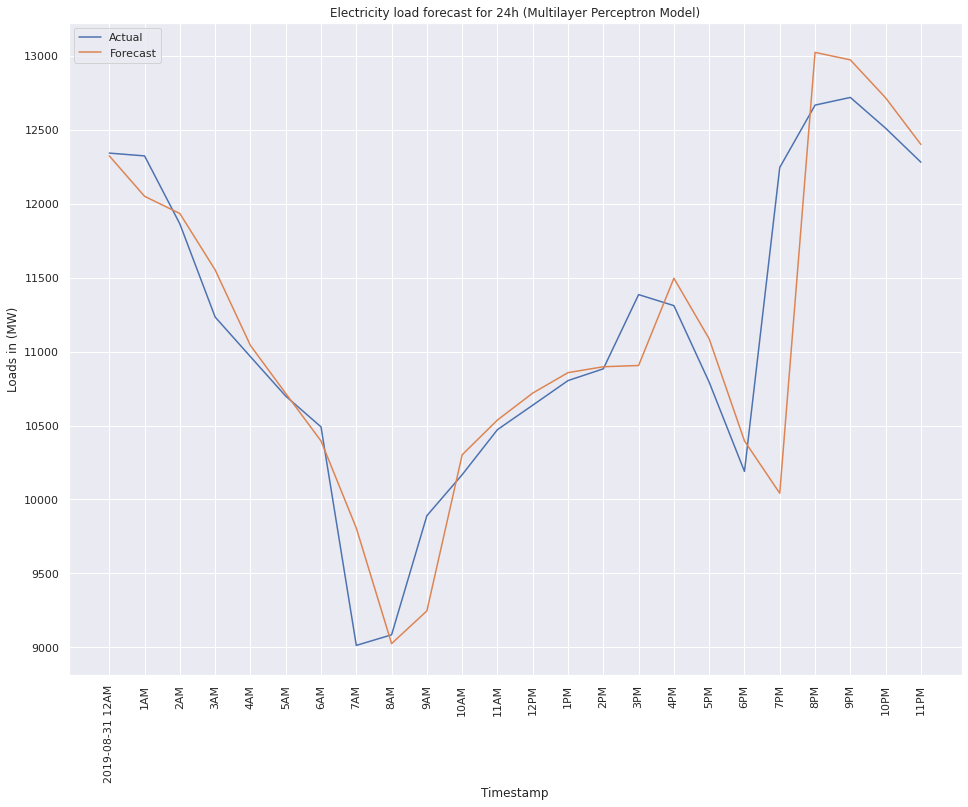

In [121]:
forecast = multivariate_mlp.predict(X_test[6:30])
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["2019-08-31 12AM", "1AM", "2AM", "3AM", "4AM", "5AM", "6AM", "7AM", "8AM", "9AM", "10AM", "11AM", "12PM", "1PM", "2PM", "3PM", "4PM", "5PM", "6PM", "7PM", "8PM", "9PM", "10PM", "11PM"]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,multivariate_mlp_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Electricity load forecast for 24h (Multilayer Perceptron Model)')
plt.xticks(rotation = 90)
plt.savefig('1.png')
plt.show()

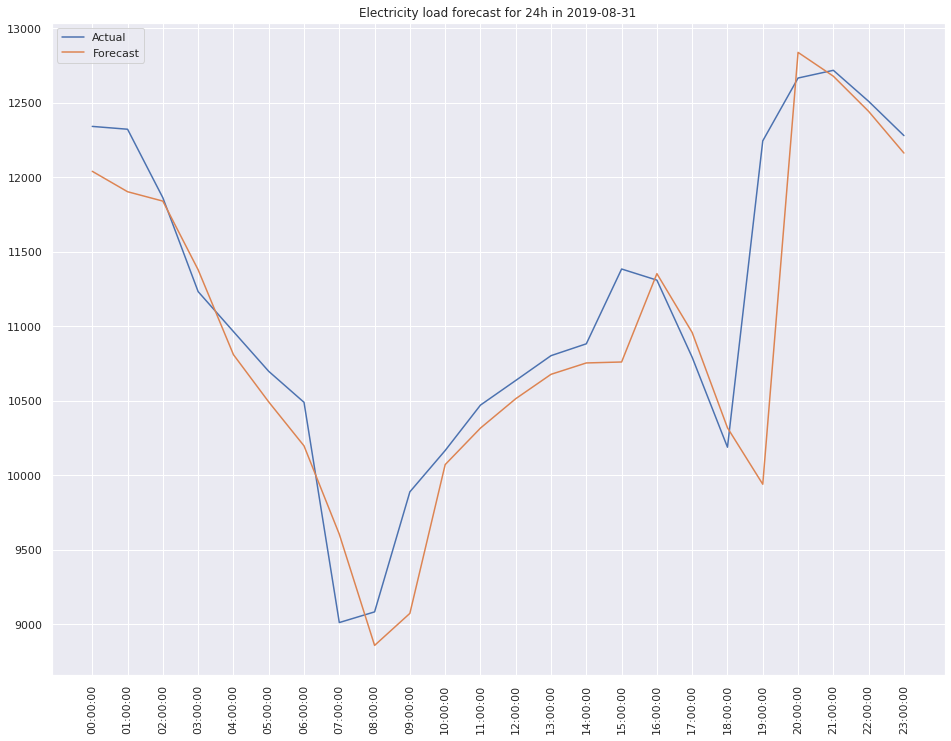

In [93]:
forecast = multivariate_mlp.predict(X_test[6:30])
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00", "08:00:00", "09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00", "18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00", "23:00:00", ]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,multivariate_mlp_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.title('Electricity load forecast for 24h in 2019-08-31')
plt.xticks(rotation = 90)
plt.show()

In [94]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of hour-ahead load multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

RMSE of hour-ahead load multivariate MLP forecast: 312.418


## <a id='ref26'>4.8. Encoder-Decoder</a> 

In [95]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=0.0003, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [96]:
history = encoder_decoder.fit(train, epochs=100,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/100
76/76 [==============================] - 8s 86ms/step - loss: 0.0542 - root_mean_squared_error: 0.2180 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 2/100
76/76 [==============================] - 7s 89ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 3/100
76/76 [==============================] - 6s 83ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0950
Epoch 4/100
76/76 [==============================] - 6s 79ms/step - loss: 0.0074 - root_mean_squared_error: 0.0857 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 5/100
76/76 [==============================] - 7s 91ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 6/100
76/76 [==============================] - 7s 88ms/step - loss: 0.0050 - root_mean_squared_error: 0.0705 - val_loss: 0.0055 - val_

<Figure size 1152x864 with 0 Axes>

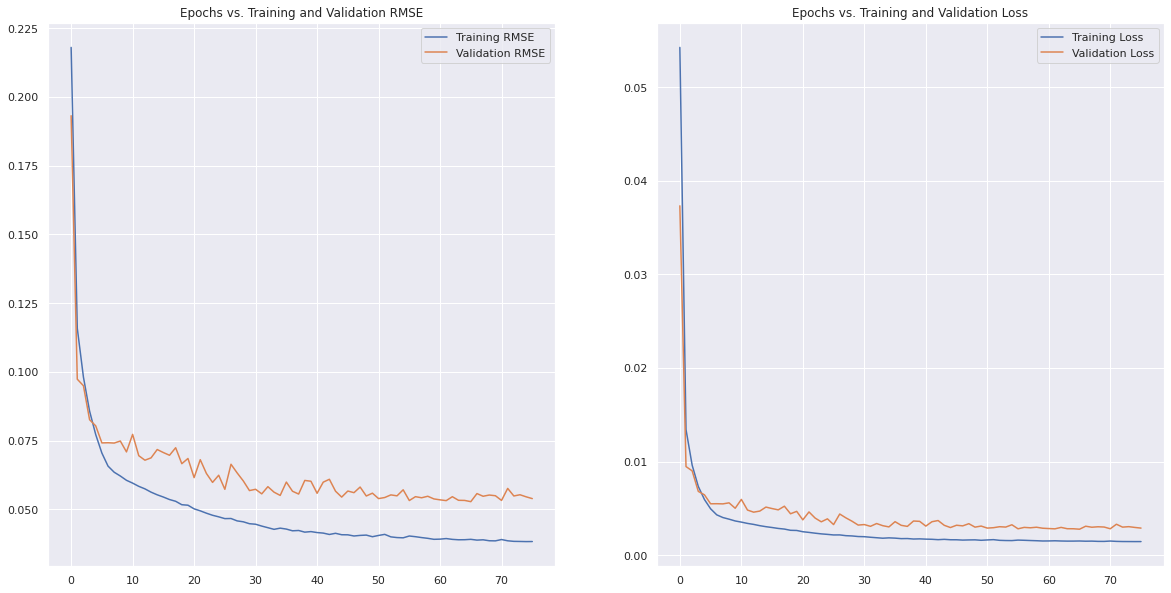

In [124]:
plt.savefig('1.png')

plot_model_rmse_and_loss(history)

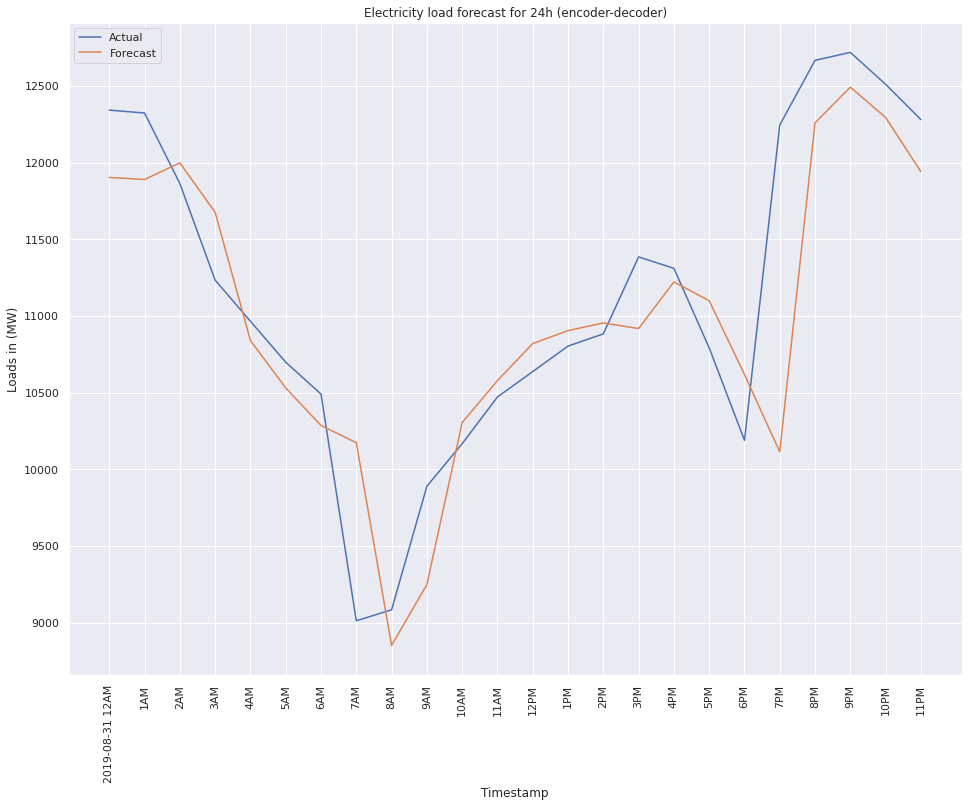

In [123]:
forecast = encoder_decoder.predict(X_test[6:30])
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["2019-08-31 12AM", "1AM", "2AM", "3AM", "4AM", "5AM", "6AM", "7AM", "8AM", "9AM", "10AM", "11AM", "12PM", "1PM", "2PM", "3PM", "4PM", "5PM", "6PM", "7PM", "8PM", "9PM", "10PM", "11PM"]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,encoder_decoder_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Electricity load forecast for 24h (encoder-decoder)')
plt.xticks(rotation = 90)
plt.savefig('1.png')
plt.show()

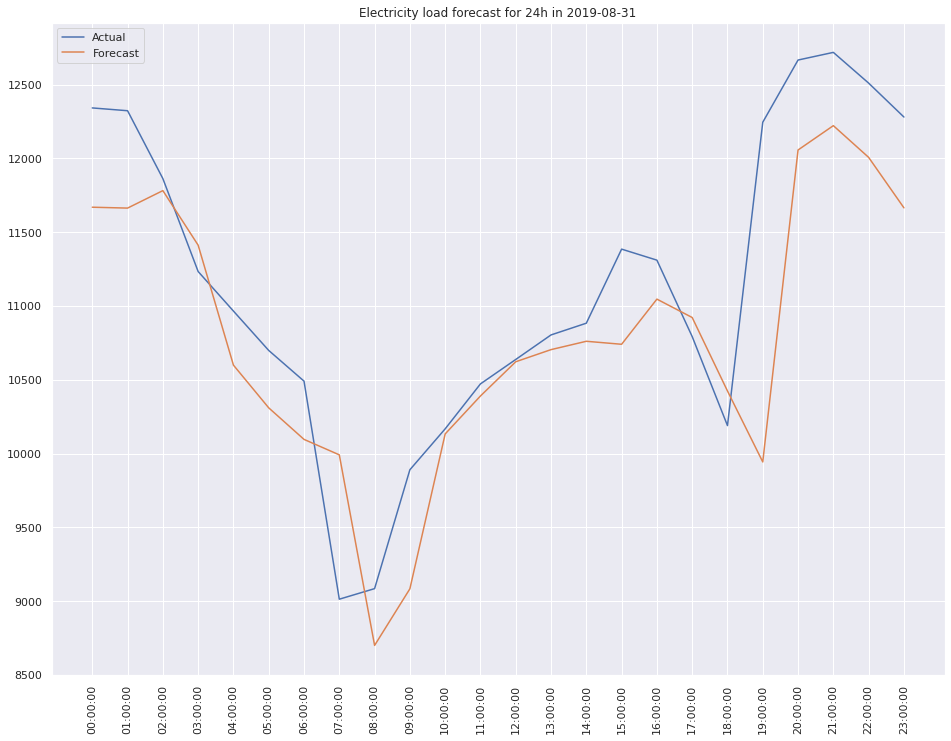

In [98]:
forecast = encoder_decoder.predict(X_test[6:30])
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

fig, ax = plt.subplots()
#x= int(range(0,24))
x=["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00", "08:00:00", "09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00", "18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00", "23:00:00", ]
#x=df_final.index[22283:][0:30]
plt.plot(x,scaler_y.inverse_transform(y_test[6:30]), label="Actual")
plt.plot(x,encoder_decoder_forecast, label="Forecast")
#plt.plot(x, y1, "-b", label="sine")
#plt.plot(x, y2, "-r", label="cosine")
plt.legend(loc="upper left")
#ax.set_xticklabels(df_final.index[22283:][0:24])
plt.xticks(x)
plt.title('Electricity load forecast for 24h in 2019-08-31')
plt.xticks(rotation = 90)
plt.show()

In [99]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of hour-ahead load Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

RMSE of hour-ahead load Encoder-Decoder forecast: 395.02


In [100]:
cols = ['maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex',
       'moon_illumination', 'moonrise', 'moonset', 'sunrise', 'sunset',
       'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
       'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph', 'location', 'loads']